# Домашнее задание 3

У вас есть данные о полетах. Для каждого клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета. 

Для некоторых клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied). По этим данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, для которых ответ неизвестен.

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

Продуктивной и интересной вам работы!

![image.png](attachment:./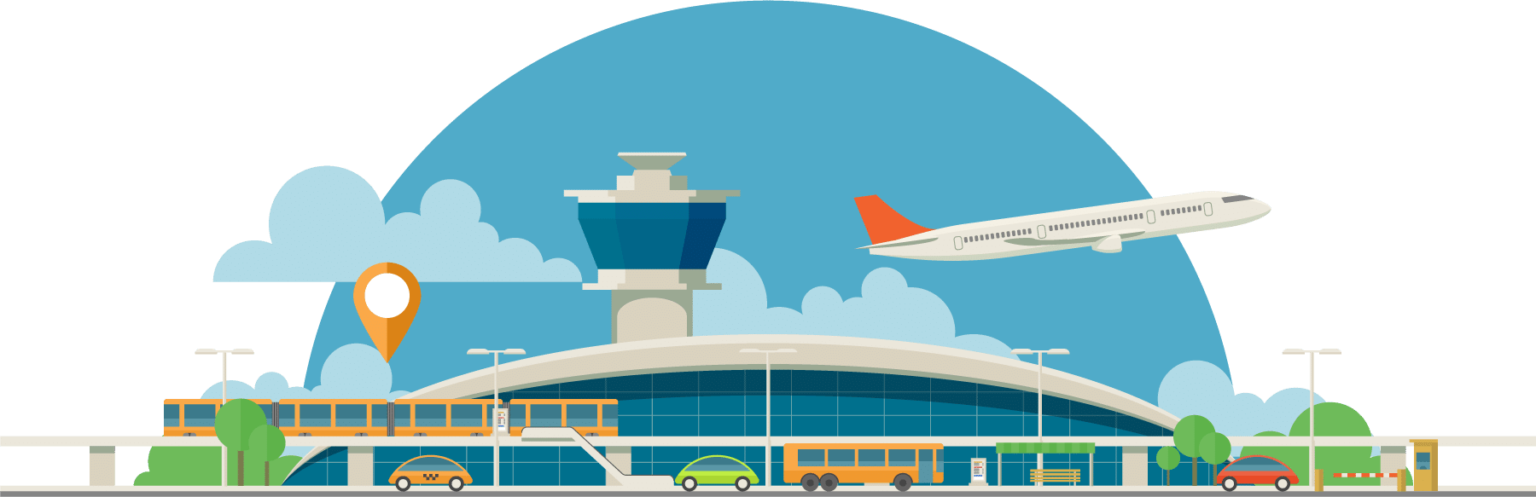)

> Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода. <br/> А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, -- текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

Брать код из открытых источников позволительно. Следование культуре цитирования при этом обязательно

In [3]:
!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
!pip install xgboost
!brew install cmake libomp
!pip install lightgbm
!pip install seaborn --upgrade


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/c3/eb/496aa2f5d356af4185f770bc76055307f8d1870e11016b10fd779b21769c/xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl.me

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions 
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

# Data Prep & EDA (3 балла)

## Загрузка и предобработка данных (1.75 балла)

In [2]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-12-31 01:34:16--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/home/pavel/.postgresql/root.crt’

/home/pavel/.postgr 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-12-31 01:34:16 (5.23 GB/s) - ‘/home/pavel/.postgresql/root.crt’ saved [3579/3579]



(0.5 балла) <font color='#9933CC'>Подключитесь к БД при помощи `psycopg2.connect()` и напишите SQL-запрос, объединяющий 3 нужные таблицы в одну</font>.
Список столбцов таблиц добудьте самостоятельно. 

<font color='#9933CC'>Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'</font>

> Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

### Параметры соединения
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

### Схема БД

![screens.png](attachment:./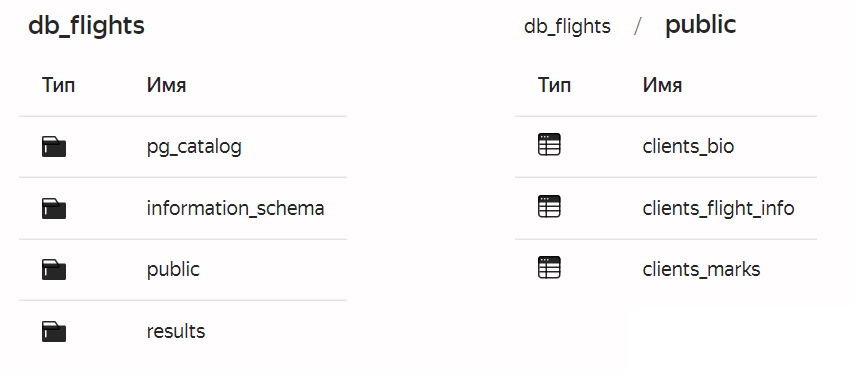)

In [3]:
conn = psycopg2.connect(
    " host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net port=6432 sslmode=verify-full dbname=db_flights user=mlhs_student password=mlhs_student target_session_attrs=read-write")
conn.set_session(autocommit=True)
cur = conn.cursor()

In [4]:
db_cols = dict()
cur.execute("SELECT column_name FROM information_schema.columns WHERE table_name = 'clients_bio'")
db_cols["clients_bio"] = [x[0] for x in cur.fetchall()]

cur.execute("SELECT column_name FROM information_schema.columns WHERE table_name = 'clients_flight_info'")
db_cols["clients_flight_info"] = [x[0] for x in cur.fetchall()]

cur.execute("SELECT column_name FROM information_schema.columns WHERE table_name = 'clients_marks'")
db_cols["clients_marks"] = [x[0] for x in cur.fetchall()]

In [5]:
def cat_query_cols(all_cols: list, table_name: str, exclude_cols: list) -> str:
    query_pattern = '{table_name}."{col_name}", '
    query_cols = ""
    for col in all_cols:
        if col not in exclude_cols:
            query_cols += query_pattern.format(table_name=table_name, col_name=col)
    return query_cols.rstrip("'")

In [6]:
selected_cols = ""
selected_cols += cat_query_cols(db_cols["clients_bio"], "clients_bio", [])
selected_cols += cat_query_cols(db_cols["clients_flight_info"], "clients_flight_info", ["id"])
selected_cols += cat_query_cols(db_cols["clients_marks"], "clients_marks", ["id"])
selected_cols = selected_cols.rstrip(", ")

In [7]:
cur.execute("""
SELECT {selected_cols}
FROM clients_bio
INNER JOIN clients_flight_info ON clients_bio.id = clients_flight_info.id
INNER JOIN clients_marks ON clients_bio.id = clients_marks.id
""".format(selected_cols=selected_cols))

In [8]:
cols = [cols for cols in list(db_cols.values())]
flat_cols = list()
for col_names in cols:
    for col_name in col_names:
        if col_name not in flat_cols:
            flat_cols.append(col_name)

df = pd.DataFrame(cur.fetchall(), columns=flat_cols).set_index("id")

In [9]:
assert df.shape == (129_549, 23)

(0.25 балла) <font color='#9933CC'>Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   gender                             129549 non-null  object
 1   age                                129549 non-null  object
 2   Customer Type                      129549 non-null  object
 3   Type of Travel                     129549 non-null  object
 4   class                              129549 non-null  object
 5   Flight Distance                    129549 non-null  object
 6   Departure Delay in Minutes         129549 non-null  object
 7   Arrival Delay in Minutes           129549 non-null  object
 8   Inflight wifi service              129549 non-null  object
 9   Departure/Arrival time convenient  129549 non-null  object
 10  Ease of Online booking             129549 non-null  object
 11  Gate location                      129549 non-null  objec

In [11]:
df = df.replace(('nan', "-"), np.nan)

In [12]:
df = df.apply(lambda x: pd.to_numeric(x, downcast="float", errors="ignore"))

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129549 non-null  object 
 1   age                                129234 non-null  float32
 2   Customer Type                      129472 non-null  object 
 3   Type of Travel                     129448 non-null  object 
 4   class                              129433 non-null  object 
 5   Flight Distance                    129455 non-null  float32
 6   Departure Delay in Minutes         129442 non-null  float32
 7   Arrival Delay in Minutes           129042 non-null  float32
 8   Inflight wifi service              129505 non-null  float32
 9   Departure/Arrival time convenient  129500 non-null  float32
 10  Ease of Online booking             129506 non-null  float32
 11  Gate location                      129512 no

In [14]:
df.isna().sum()

gender                                   0
age                                    315
Customer Type                           77
Type of Travel                         101
class                                  116
Flight Distance                         94
Departure Delay in Minutes             107
Arrival Delay in Minutes               507
Inflight wifi service                   44
Departure/Arrival time convenient       49
Ease of Online booking                  43
Gate location                           37
Food and drink                          50
Online boarding                         46
Seat comfort                            47
Inflight entertainment                  45
On-board service                        44
Leg room service                        46
Baggage handling                        48
Checkin service                         42
Inflight service                        63
cleanliness                             37
satisfaction                         25905
dtype: int6

In [15]:
print("Количество выбросов:")
for col in df.select_dtypes("float").columns:
    q99 = df[col].quantile(0.99)
    q001 = df[col].quantile(0.01)
    print(f"{col}: {len(df[df[col] > q99][col]) + len(df[df[col] < q001][col])}")

Количество выбросов:
age: 1809
Flight Distance: 2323
Departure Delay in Minutes: 1291
Arrival Delay in Minutes: 1271
Inflight wifi service: 34
Departure/Arrival time convenient: 39
Ease of Online booking: 30
Gate location: 44
Food and drink: 169
Online boarding: 34
Seat comfort: 49
Inflight entertainment: 49
On-board service: 37
Leg room service: 643
Baggage handling: 35
Checkin service: 44
Inflight service: 49
cleanliness: 47


(0.5 балла) <font color='#9933CC'>Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме</font>

Нас интересует `matrix` пропущенных значений и столбцатая диаграмма в логарифмированной шкале (*пропусков немного => по обычной не будет видно, в каких столбцах их больше*)

<Axes: >

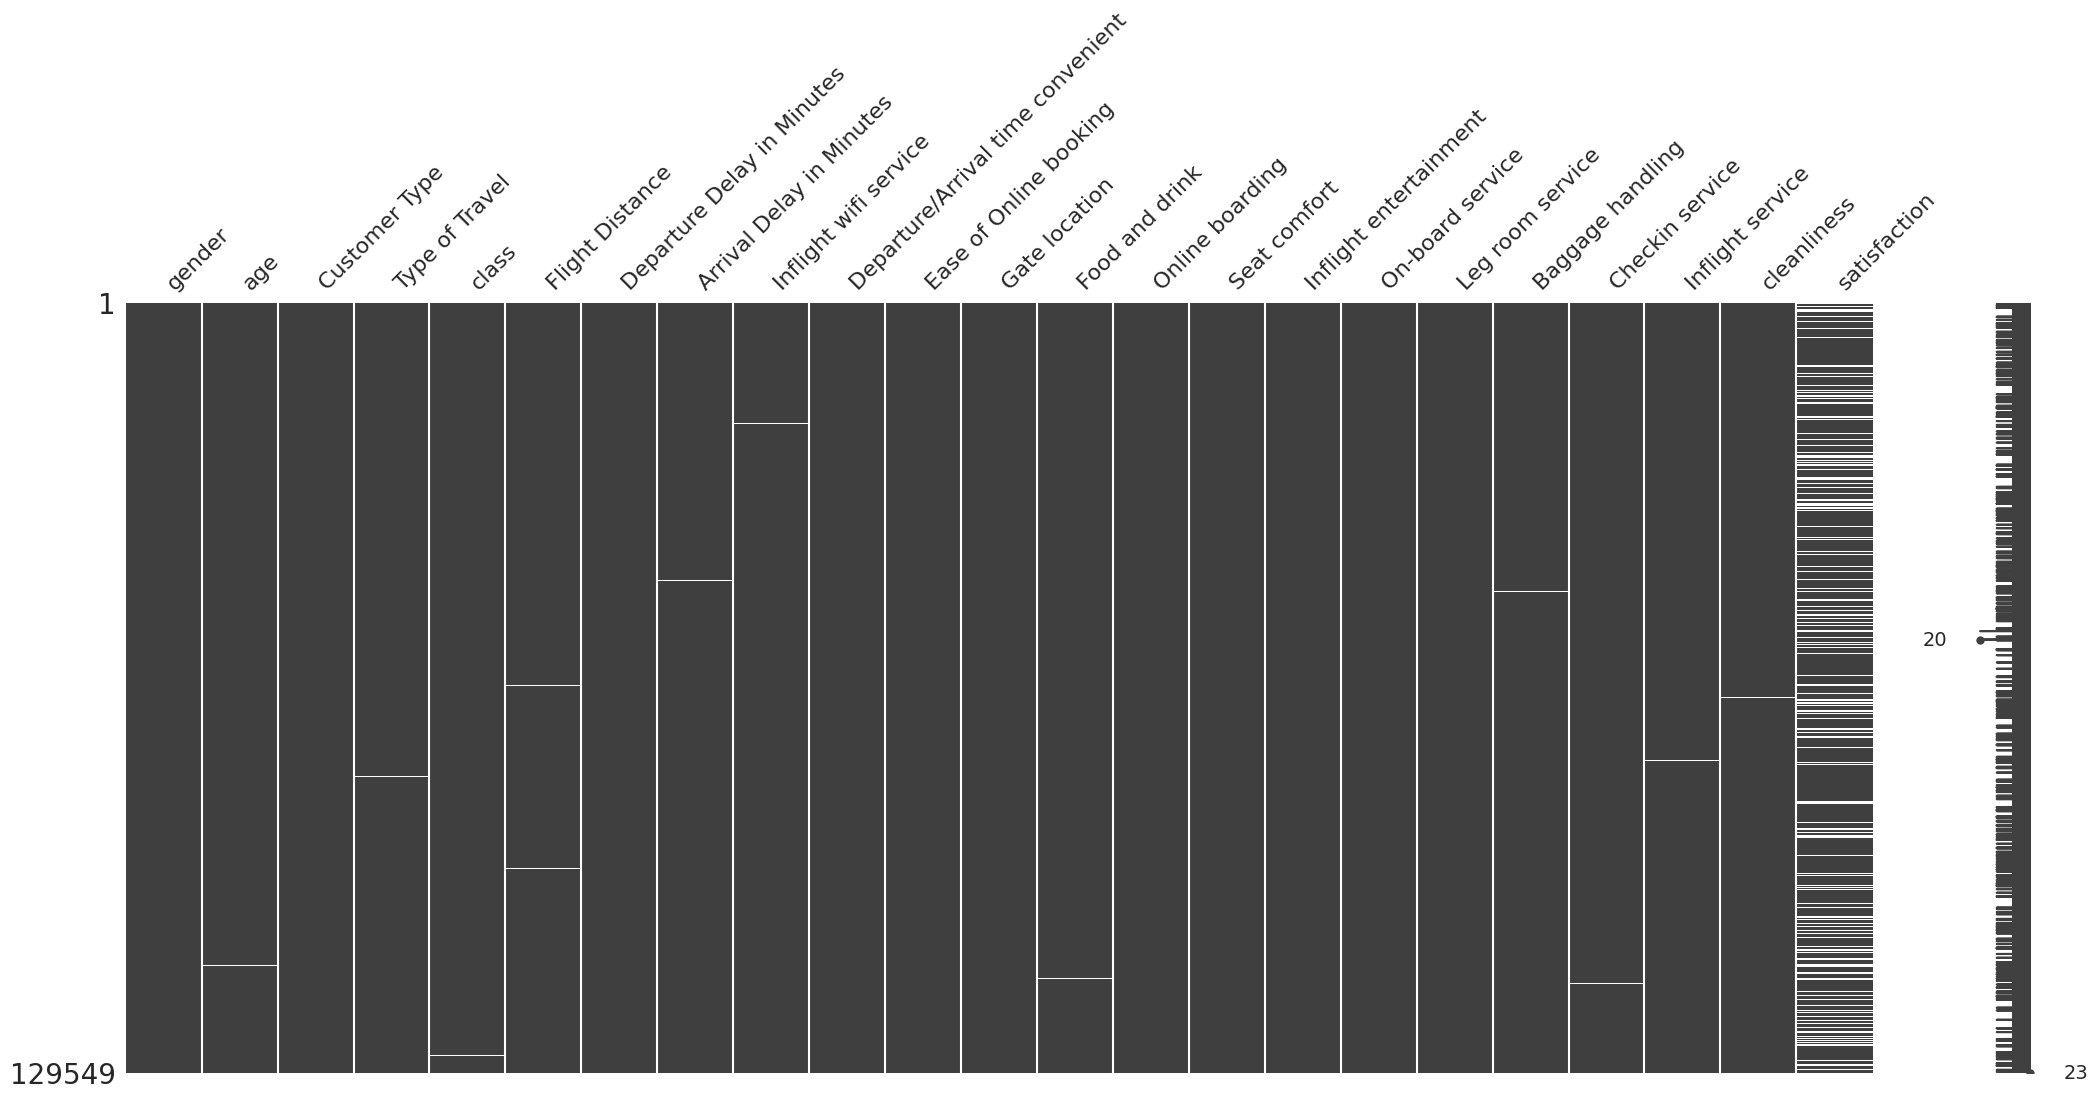

In [16]:
missingno.matrix(df)

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


<Axes: >

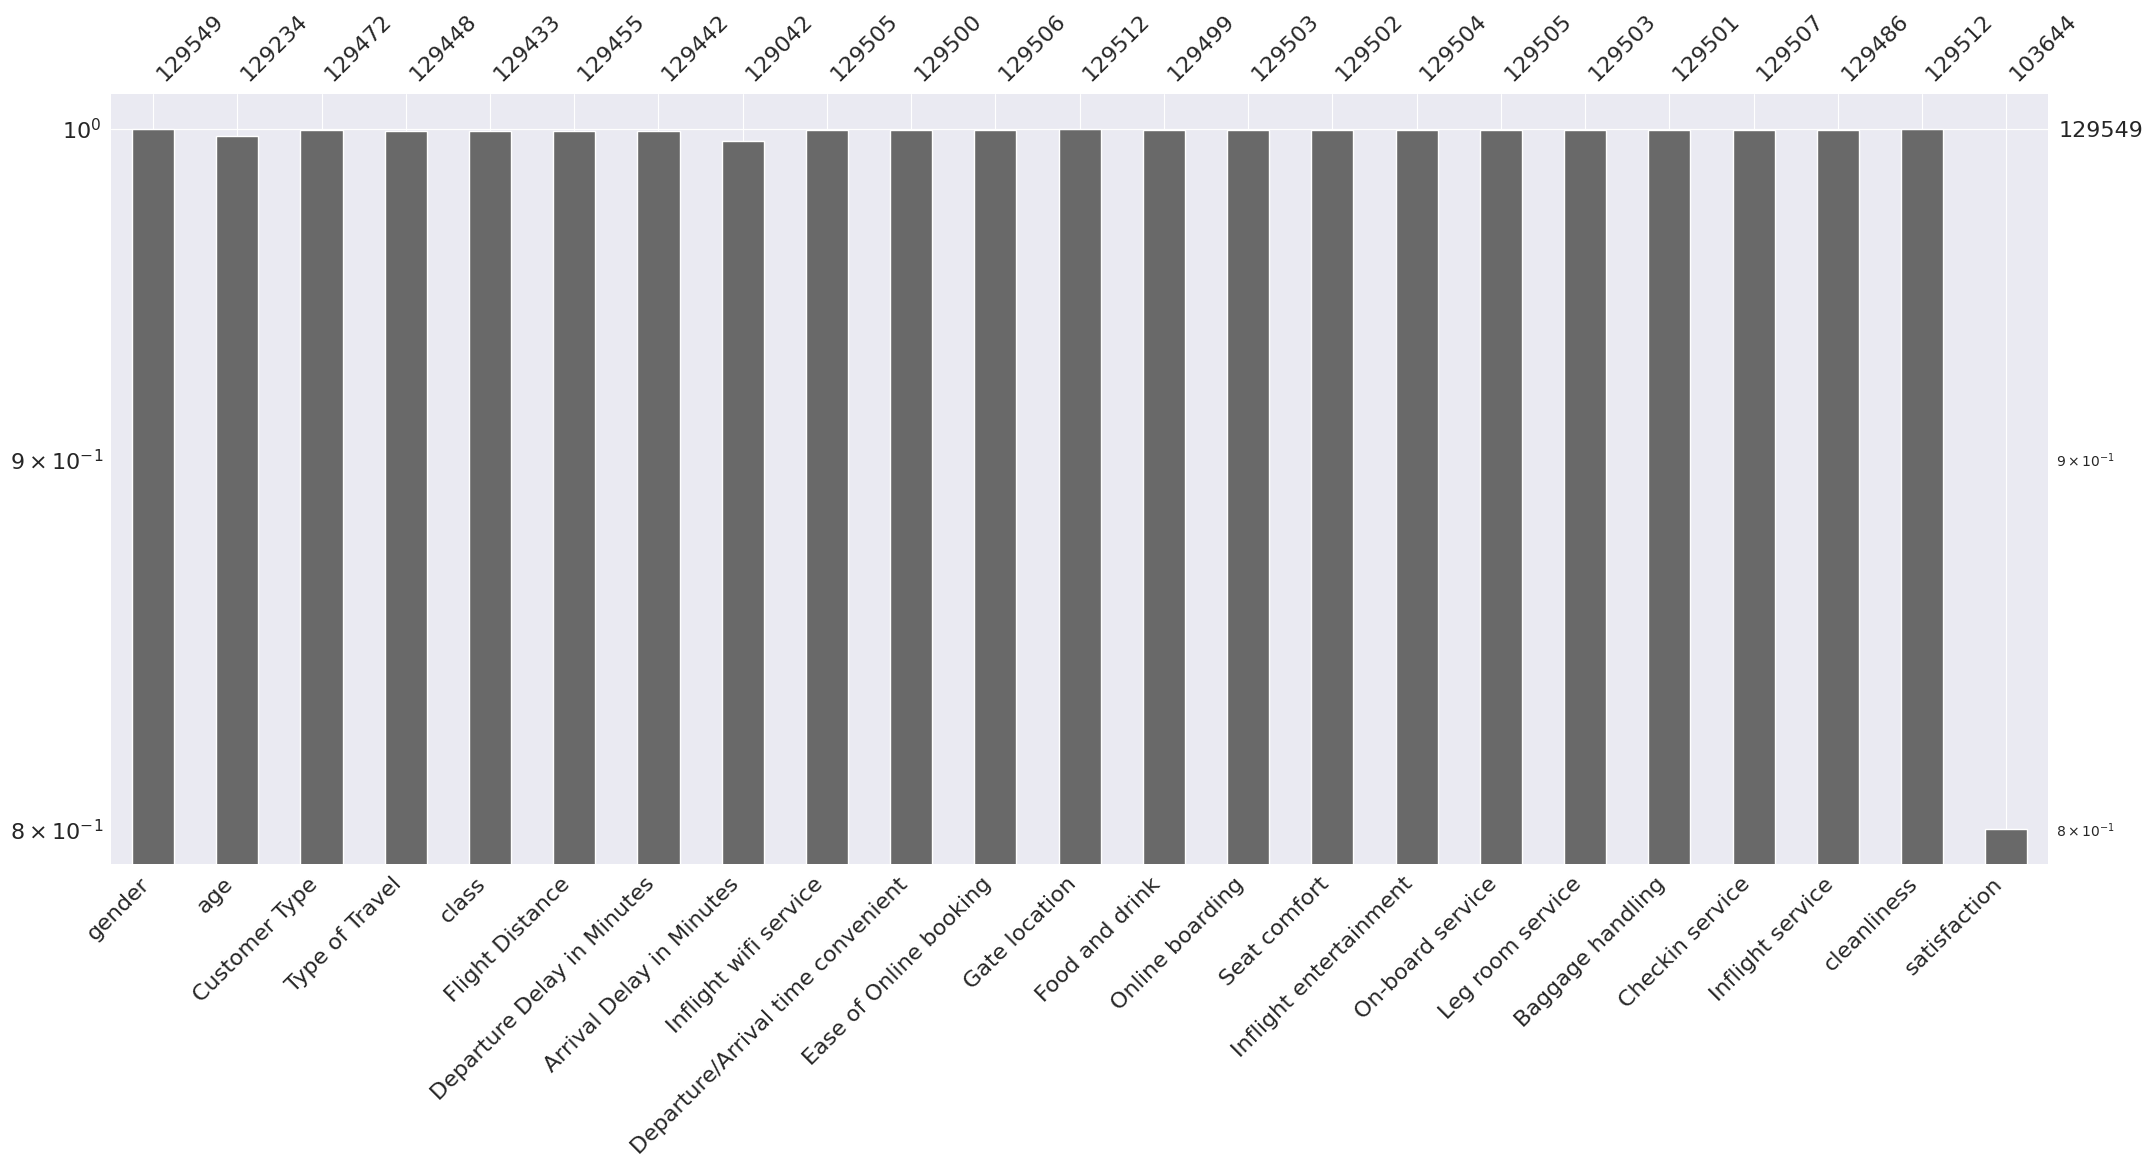

In [17]:
missingno.bar(df, log=True)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука

In [18]:
df_train = df[df.satisfaction.notna()]
df_train

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
7         Male  43.0     Loyal Customer  Business travel  Business   
13        Male  24.0  disloyal Customer  Business travel       Eco   
18      Female  61.0     Loyal Customer  Personal Travel       Eco   
31        Male  35.0  disloyal Customer  Business travel  Business   
39      Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129831  Female  28.0     Loyal Customer  Personal Travel       Eco   
129837    Male  66.0     Loyal Customer  Personal Travel       Eco   
129838  Female  59.0     Loyal Customer  Personal Travel       Eco   
129839    Male  61.0     Loyal Customer  Personal Travel       Eco   
129846    Male  44.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
7                1963.0                         0.0                       0.0   
13                453.0                        16.0                      30.0   
18                821.0                         0.0                       0.0   
31                212.0                         0.0                       0.0   
39                 67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129831            447.0                        23.0                      16.0   
129837            337.0                       199.0                     213.0   
129838            308.0                        32.0                      24.0   
129839            337.0                         0.0                       0.0   
129846            447.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
7                         3.0                                3.0  ...   
13                        2.0                                2.0  ...   
18                        2.0                                5.0  ...   
31                        2.0                                2.0  ...   
39                        3.0                                3.0  ...   
...                       ...                                ...  ...   
129831                    1.0                                3.0  ...   
129837                    2.0                                4.0  ...   
129838                    3.0                                5.0  ...   
129839                    2.0                                4.0  ...   
129846                    2.0                                5.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
7                   4.0           5.0                     5.0   
13                  2.0           5.0                     5.0   
18                  1.0           5.0                     5.0   
31                  2.0           2.0                     2.0   
39                  5.0           4.0                     4.0   
...                 ...           ...                     ...   
129831              1.0           3.0                     3.0   
129837              5.0           5.0                     5.0   
129838              5.0           5.0                     3.0   
129839              2.0           3.0                     3.0   
129846              2.0           5.0                     5.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                              
7                    5.0               5.0               5.0              4.0   
13  

In [19]:
assert df_train.shape == (103_644, 23)

In [20]:
df_test = df[df.satisfaction.isna()].drop('satisfaction', axis=1)
df_test

gender   age   Customer Type   Type of Travel     class  \
id                                                                
55        Male  36.0  Loyal Customer  Business travel  Business   
79      Female  70.0  Loyal Customer  Personal Travel       Eco   
126       Male  66.0  Loyal Customer  Personal Travel       Eco   
199     Female  60.0  Loyal Customer  Business travel  Business   
263       Male  43.0  Loyal Customer  Personal Travel  Business   
...        ...   ...             ...              ...       ...   
129750    Male  38.0  Loyal Customer  Business travel       Eco   
129771    Male  16.0  Loyal Customer  Personal Travel       Eco   
129798  Female  43.0  Loyal Customer  Personal Travel       Eco   
129868    Male  47.0  Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0  Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
55               3655.0                        40.0                      71.0   
79                108.0                        50.0                      41.0   
126               562.0                        88.0                      84.0   
199              3756.0                        36.0                      24.0   
263               802.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129750            337.0                        92.0                      82.0   
129771            308.0                         2.0                       0.0   
129798            308.0                         0.0                       0.0   
129868            447.0                         0.0                       0.0   
129876            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
55                        1.0                                1.0  ...   
79                        5.0                                4.0  ...   
126                       2.0                                5.0  ...   
199                       4.0                                4.0  ...   
263                       1.0                                2.0  ...   
...                       ...                                ...  ...   
129750                    4.0                                3.0  ...   
129771                    3.0                                4.0  ...   
129798                    2.0                                4.0  ...   
129868                    3.0                                4.0  ...   
129876                    4.0                                4.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
id                                                                              
55                 1.0              3.0           3.0                     3.0   
79                 4.0              4.0           4.0                     3.0   
126                5.0              2.0           5.0                     5.0   
199                2.0              4.0           5.0                     4.0   
263                2.0              3.0           3.0                     2.0   
...                ...              ...           ...                     ...   
129750             4.0              5.0           4.0                     4.0   
129771             1.0              3.0           5.0                     1.0   
129798             3.0              5.0           5.0                     4.0   
129868             4.0              3.0           4.0                     4.0   
129876             4.0              4.0           1.0                     4.0   

        On-board service  Leg room service  Baggage handling  Checkin service 

In [21]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [22]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [23]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

(0.25 балла) <font color='#9933CC'>Заполните пропуски в данных наиболее часто встречающимся значением</font>.
Обратите внимание, что правильная стратегия заполнения пропусков выглядит так:

* посчитать моды для `X_train`
* ими заполнить пропуски в `X_train`, `X_val` и `df_test`

Было бы неплохо воспользоваться другой стратегией: восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Но для признаков в нашей задаче они в чистом виде бы, увы, скорее, не подошли. Импьютеры возвращали бы вещественные значения, а в нашей задаче все признаки целые. 

В общем, для изящного и удобного для применения в пайплайне заполнения пропусков, пришлось бы кодить самописные классы. Этим можете заняться в бонусной части.

In [24]:
train_modes = X_train.mode().T.to_dict()[0]

In [25]:
X_train = X_train.fillna(value=train_modes)
X_val = X_val.fillna(value=train_modes)
df_test = df_test.fillna(value=train_modes)

<font color='#9933CC'>Выведите основные статистики по числовым и категориальным столбцам таблицы `X_train`</font>

In [26]:
X_train.describe(include="all")

gender           age   Customer Type   Type of Travel     class  \
count    72550  72550.000000           72550            72550     72550   
unique       2           NaN               2                2         3   
top     Female           NaN  Loyal Customer  Business travel  Business   
freq     36816           NaN           59406            50054     34793   
mean       NaN     40.098854             NaN              NaN       NaN   
std        NaN     20.658195             NaN              NaN       NaN   
min        NaN      0.000000             NaN              NaN       NaN   
25%        NaN     27.000000             NaN              NaN       NaN   
50%        NaN     40.000000             NaN              NaN       NaN   
75%        NaN     51.000000             NaN              NaN       NaN   
max        NaN    544.000000             NaN              NaN       NaN   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
count      72550.000000                72550.000000              72550.000000   
unique              NaN                         NaN                       NaN   
top                 NaN                         NaN                       NaN   
freq                NaN                         NaN                       NaN   
mean        1329.018311                   15.859366                 16.645967   
std         4764.369629                   70.861938                 97.990295   
min            0.000000                    0.000000                  0.000000   
25%          413.000000                    0.000000                  0.000000   
50%          844.000000                    0.000000                  0.000000   
75%         1744.000000                   12.000000                 13.000000   
max       379620.000000                 9282.000000              11760.000000   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
count            72550.000000                       72550.000000  ...   
unique                    NaN                                NaN  ...   
top                       NaN                                NaN  ...   
freq                      NaN                                NaN  ...   
mean                 2.733687                           3.065017  ...   
std                  1.362172                           1.552254  ...   
min                  0.000000                           0.000000  ...   
25%                  2.000000                           2.000000  ...   
50%                  3.000000                           3.000000  ...   
75%                  4.000000                           4.000000  ...   
max                 45.000000                          45.000000  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
count     72550.000000     72550.000000  72550.000000            72550.000000   
unique             NaN              NaN           NaN                     NaN   
top                NaN              NaN           NaN                     NaN   
freq               NaN              NaN           NaN                     NaN   
mean          3.209318         3.256513      3.445665                3.362150   
std           1.349963         1.372739      1.346077                1.360862   
min           0.000000         0.000000      0.000000                0.000000   
25%           2.000000         2.000000      2.000000                2.000000   
50%           3.000000         3.000000      4.000000                4.000000   
75%           4.000000         4.000000      5.000000                4.000000   
max          36.000000        32.000000     45.000000               40.000000   

        On-board service  Leg room service  Baggage handling  Checkin service  \
count       72550.000000      72550.000000      72550.000000     72550.000000   
unique               NaN               NaN               NaN              NaN   
top                  NaN               Na

<font color='#FF6600'>Что вы можете сказать про распределение значений признаков?</font>

В первую очередь, видны выбросы как в большую, так и в меньшую сторону. Например, для числовых: age - 544, Flight Distance - 0, а для категориальных: Ease of Online booking - 28 баллов, Seat comfort - 45 баллов.

(0.25 балла) <font color='#9933CC'>Удалите строки c выбросами в числовых столбцах</font> (для трейна и валидации; тест оставьте без изменений). Выбросами считайте значения признака, строго превышающие 0.996-квантиль


---
<br/>

*Откуда взялся именно 0.996-квантиль?*

*В рамках анализа данных на выборсы вы вполне могли заметить, какие значения признаков встречаются редко. В среднем для всех признаков эти значения начинаются ~в этом квантиле*

In [27]:
for col in X_train.select_dtypes("float").columns:
    q_mask = X_train[col] <= X_train[col].quantile(0.996)
    X_train = X_train[q_mask]
    y_train = y_train[q_mask]

In [28]:
for col in X_val.select_dtypes("float").columns:
    q_mask = X_val[col] <= X_val[col].quantile(0.996)
    X_val = X_val[q_mask]
    y_val = y_val[q_mask]

## EDA (1.25 балла)

Создадим переменные с перечислениями столбцов разного типа

In [32]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols)) 
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [33]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

(0.5 балла) <font color='#9933CC'>Напишите процедуры для отрисовки графиков</font>

* Для признаков, которые мы выделили как порядковые, отображайте только `countplot`
* Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)
* Для категориальных -- только `countplot`

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

> Все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима

In [56]:
def plot_ordinal(cols, df, y):
    for col in cols:
        plt.figure(figsize=(10, 5))
        unique_labels = np.unique(y)
        labels_order = unique_labels[np.argsort(np.unique(y))]
        sns.countplot(data=df, x=col, hue=y, hue_order=labels_order)
        plt.show()

In [57]:
def plot_continuous(cols, df, y):
    for col in cols:
        fig, ax = plt.subplots(1, 2, figsize=(15, 9))
        unique_labels = np.unique(y)
        labels_order = unique_labels[np.argsort(np.unique(y))]
        sns.kdeplot(data=df, x=col, hue=y, ax=ax[0], hue_order=labels_order)
        sns.boxplot(data=df, x=col, y=y, ax=ax[1], order=labels_order)
        fig.tight_layout()
        plt.show()

In [58]:
def plot_categorical(cols, df, y):
    for col in cols:
        plt.figure(figsize=(10, 5))
        unique_labels = np.unique(y)
        labels_order = unique_labels[np.argsort(np.unique(y))]
        sns.countplot(data=df, x=col, hue=y, hue_order=labels_order)
        plt.show()

<font color='#9933CC'>Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне</font>

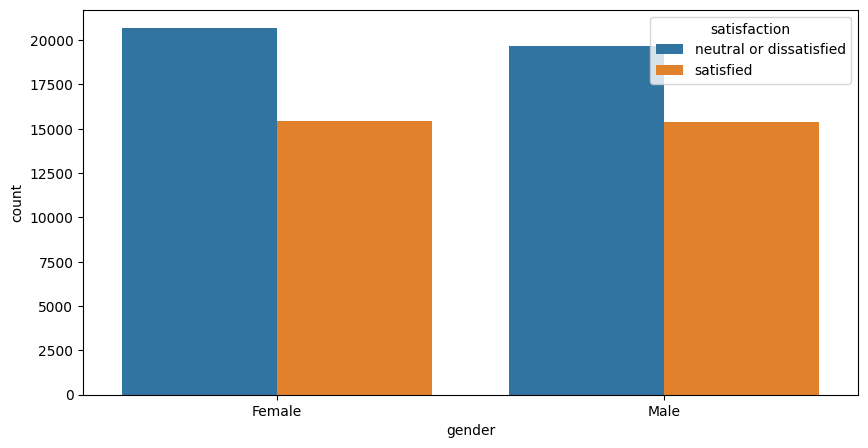

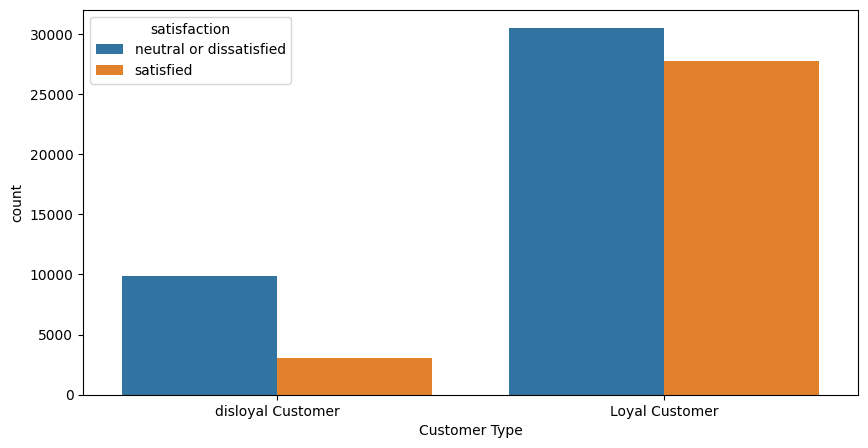

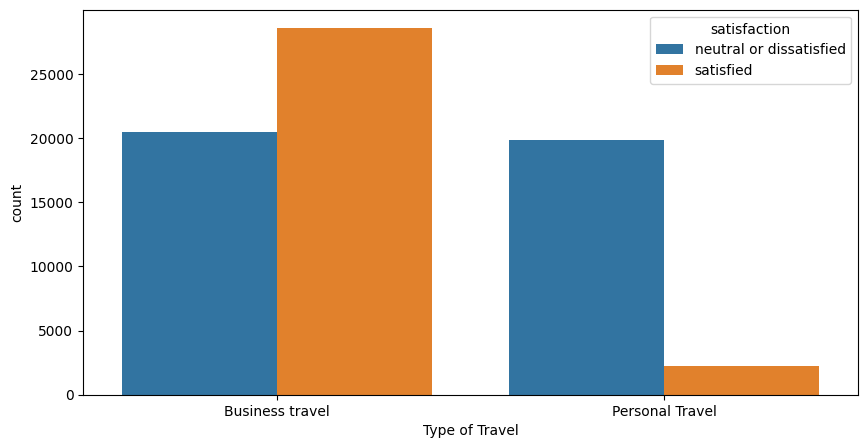

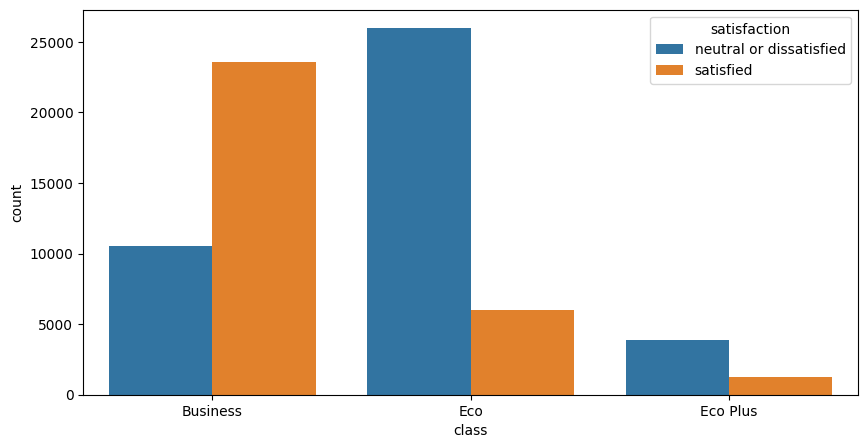

In [59]:
plot_categorical(categorical_cols, X_train, y_train)

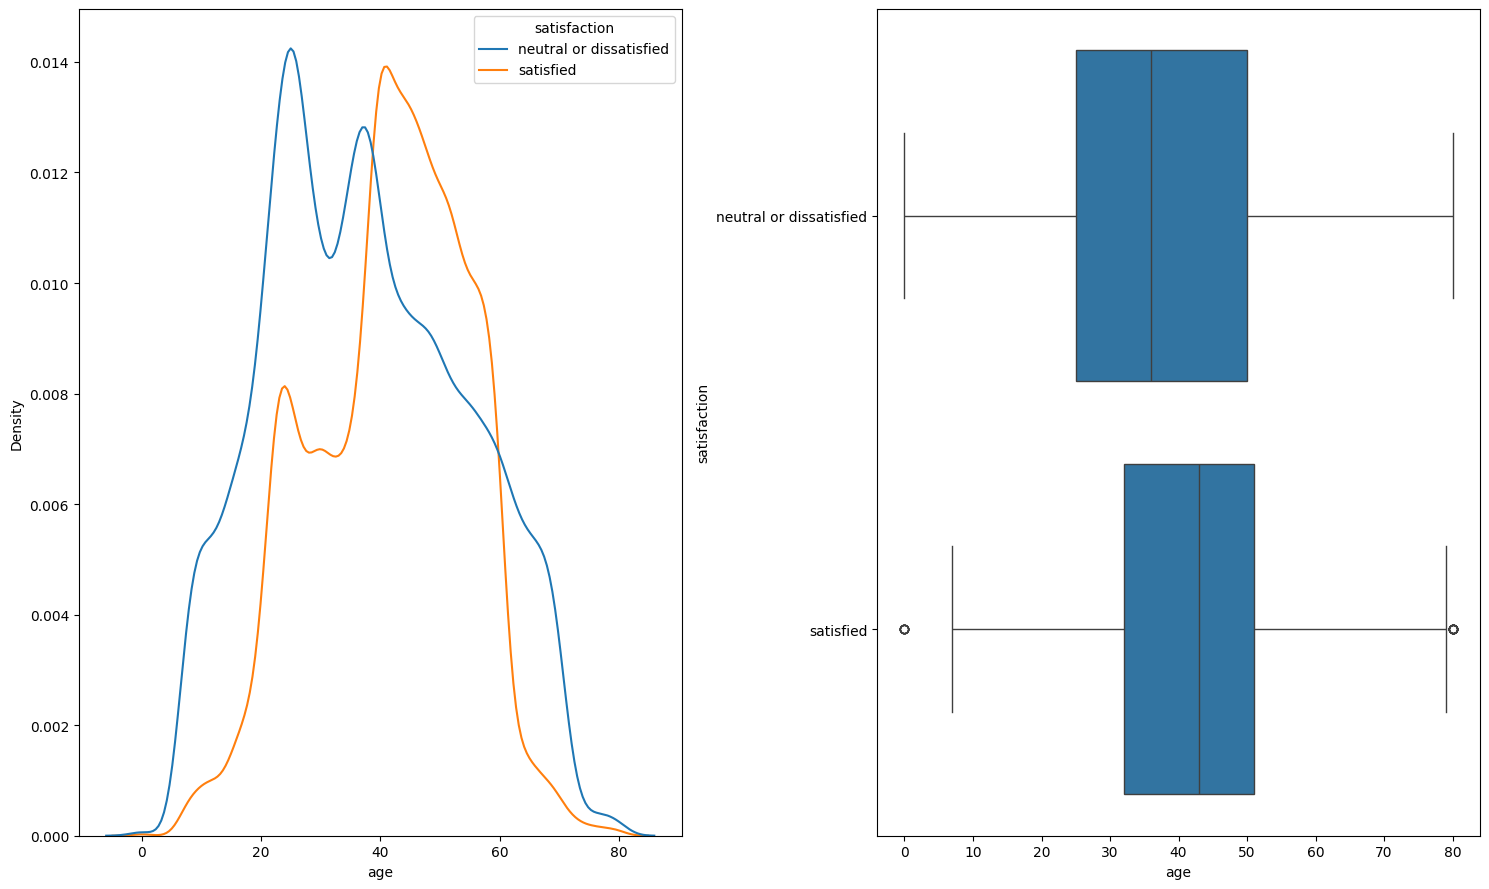

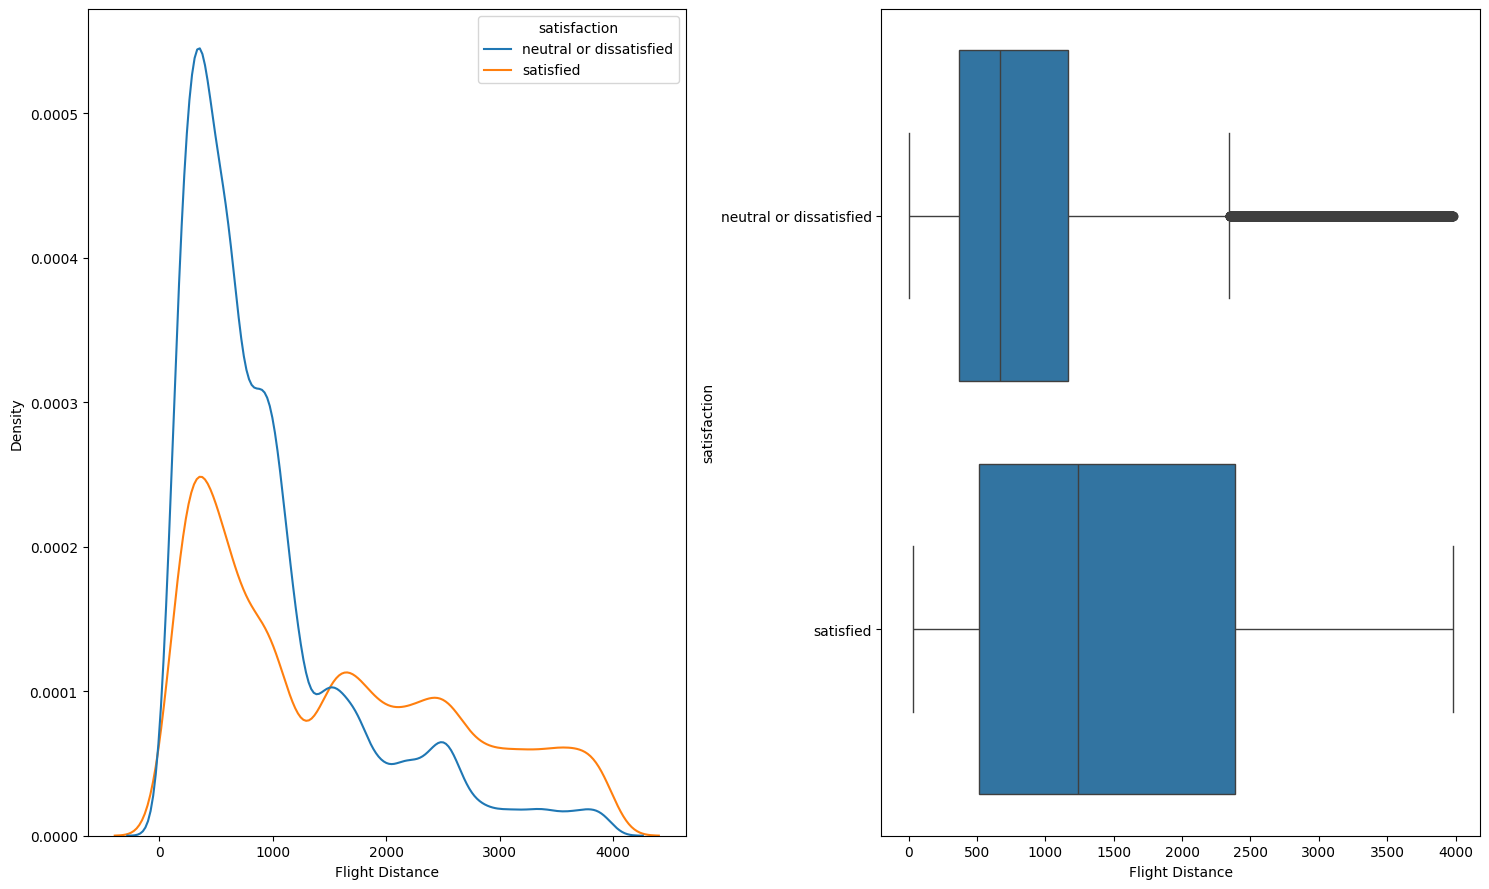

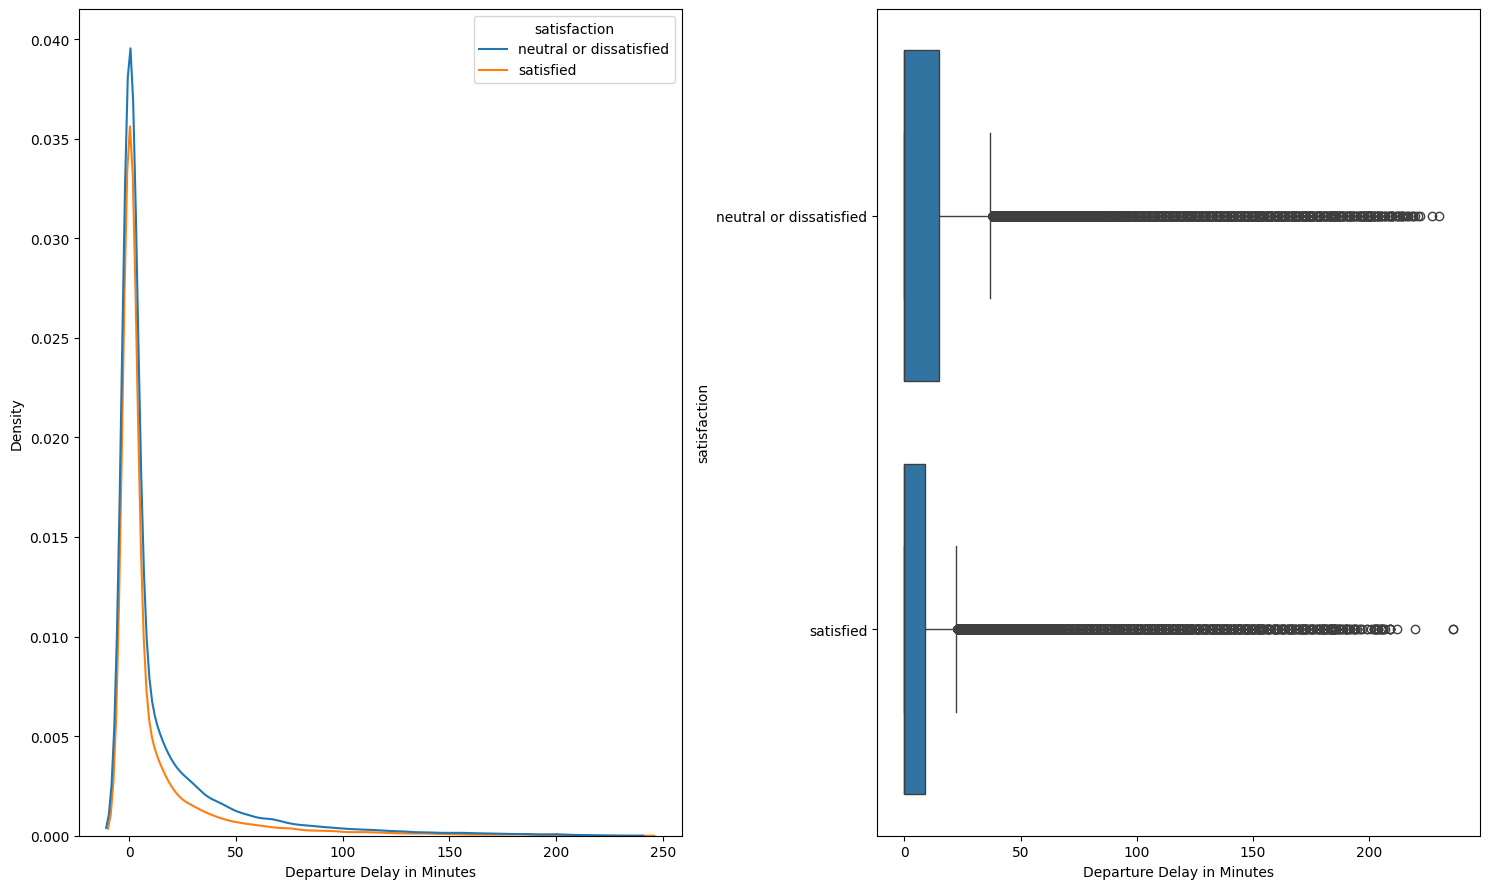

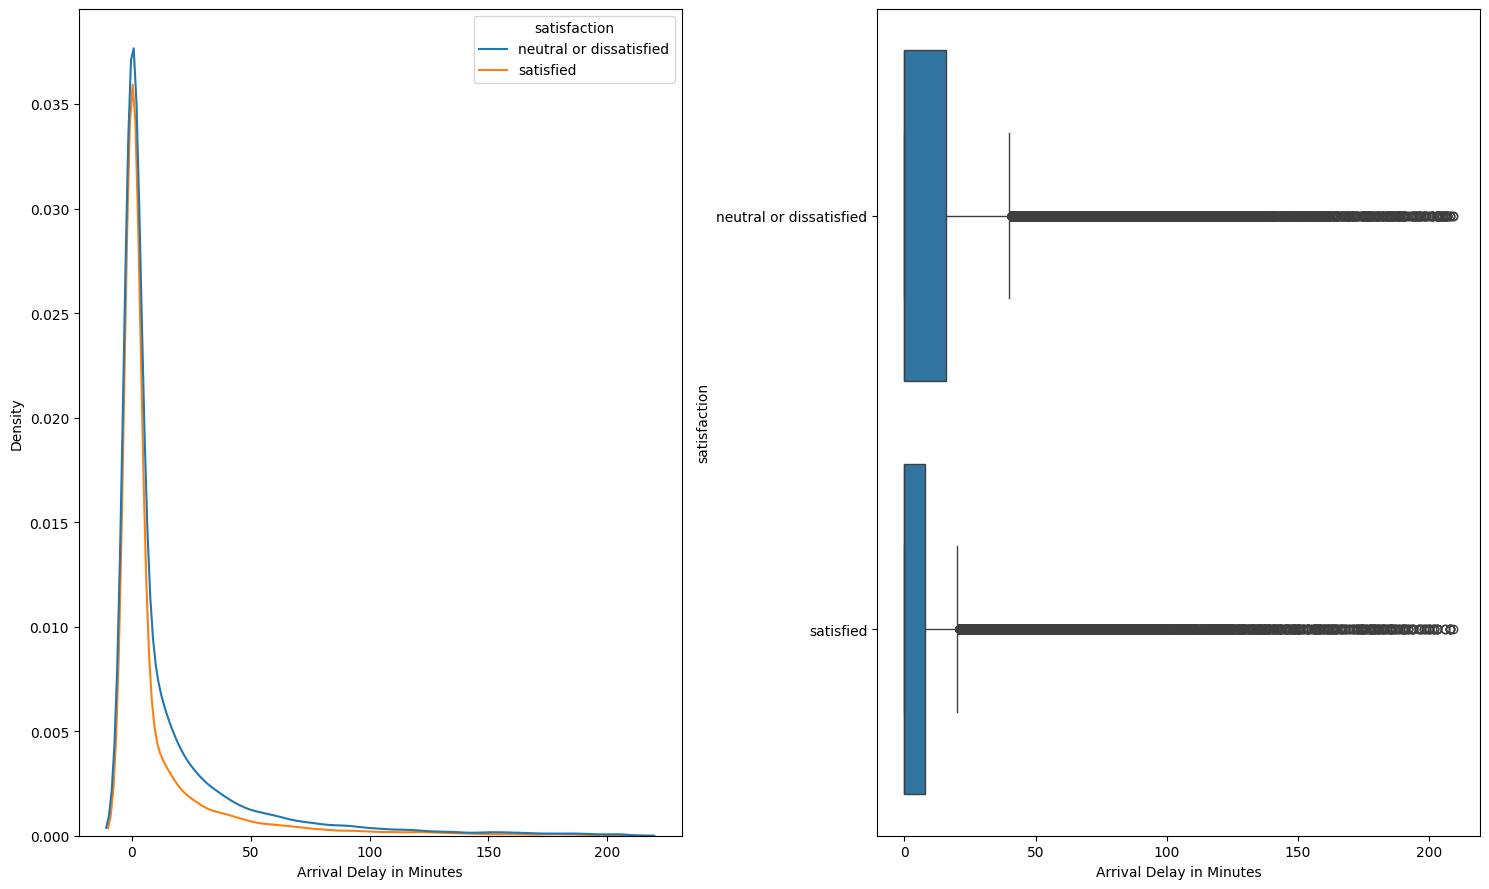

In [60]:
plot_continuous(continuous_cols, X_train, y_train)

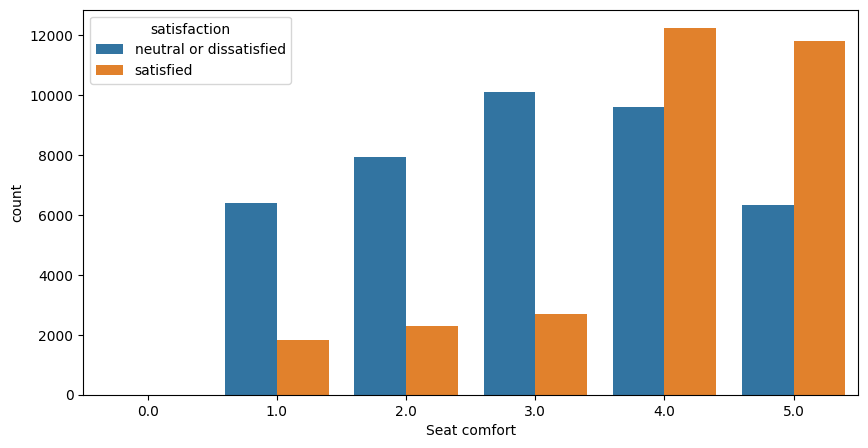

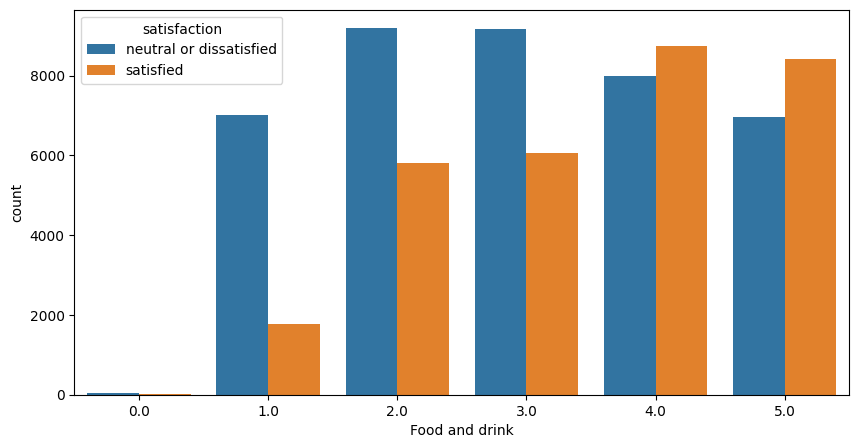

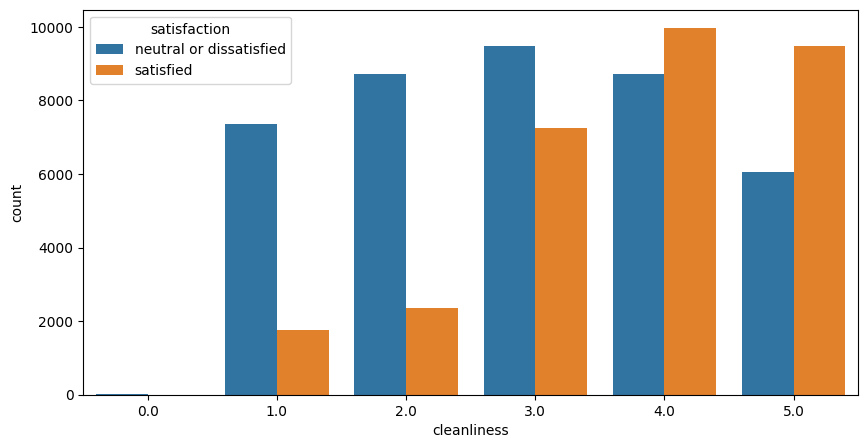

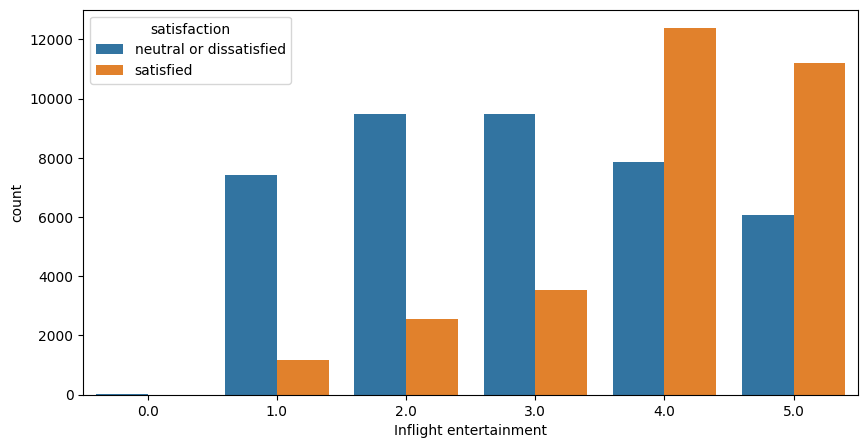

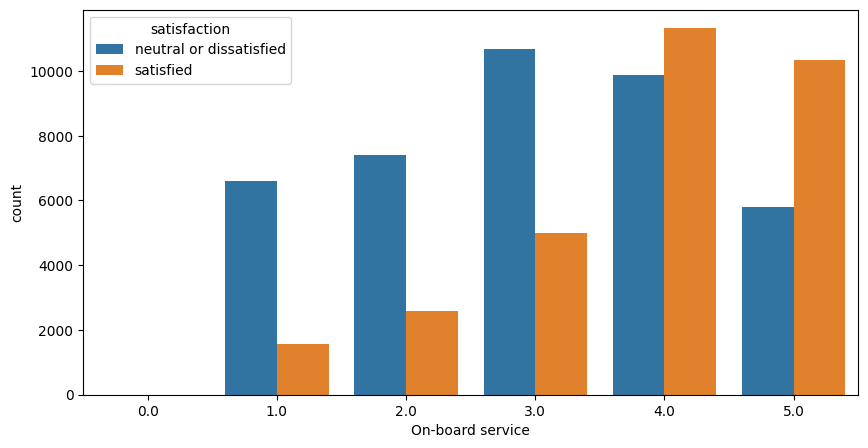

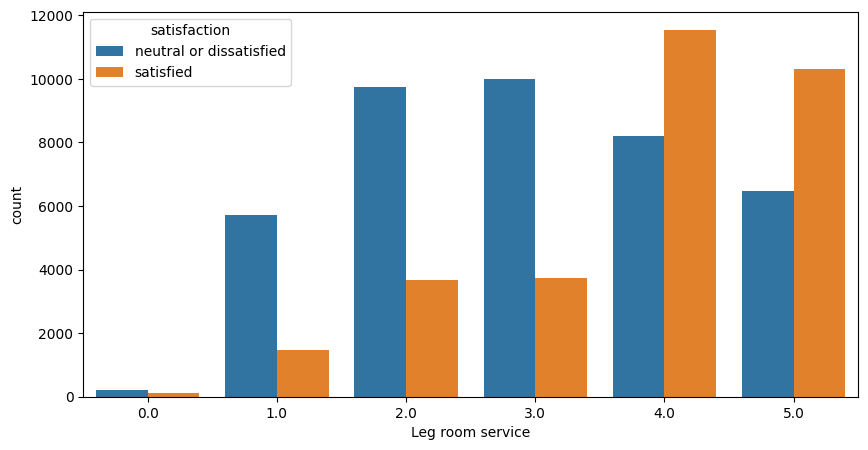

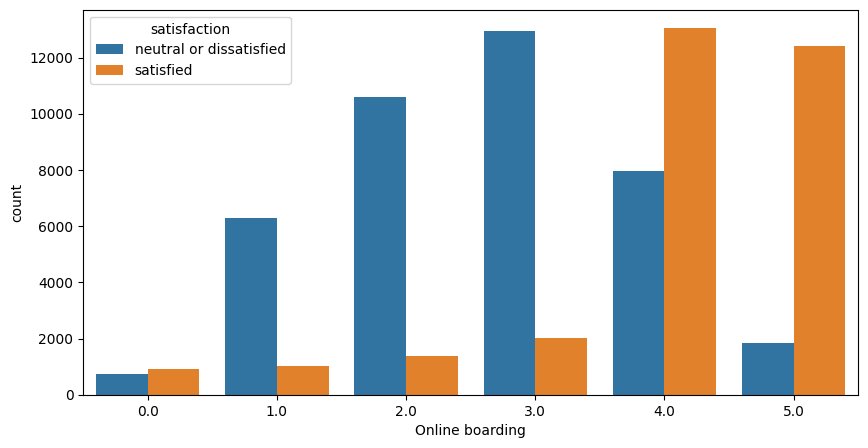

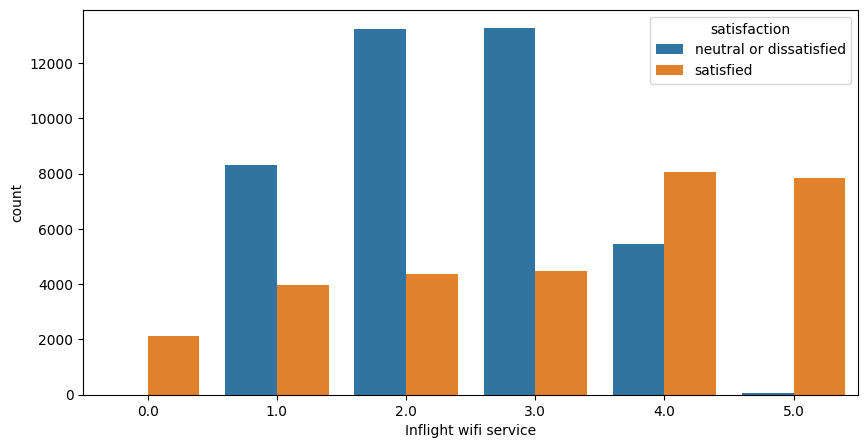

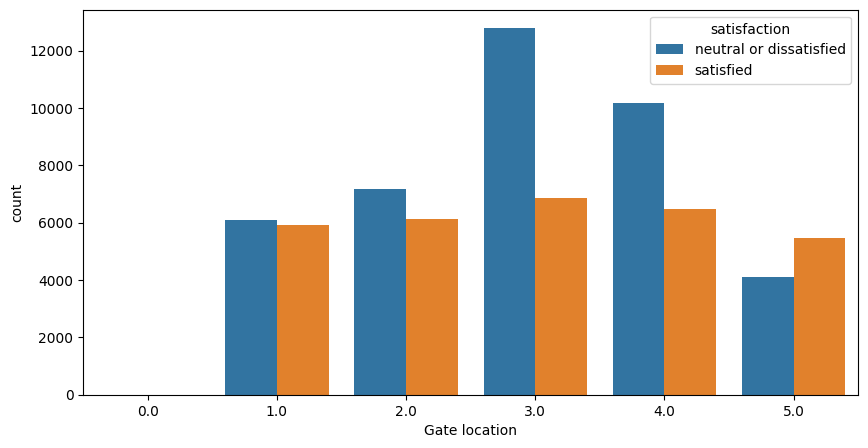

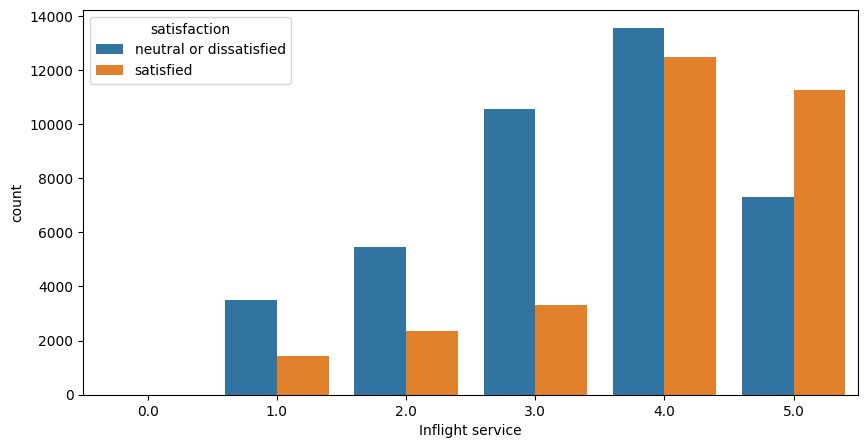

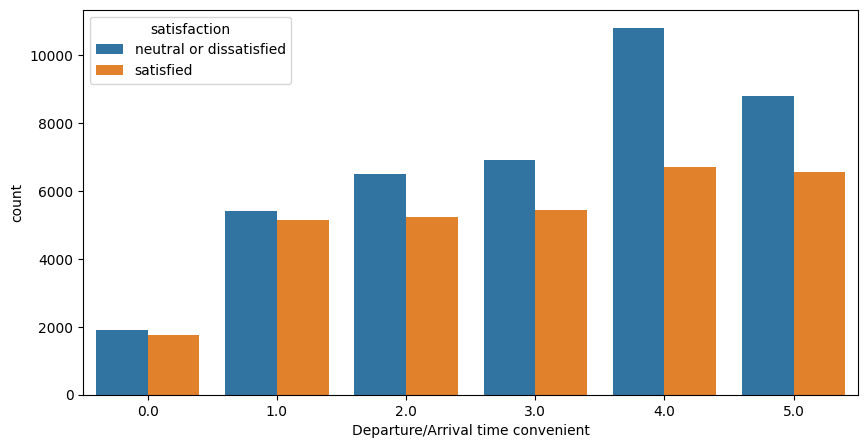

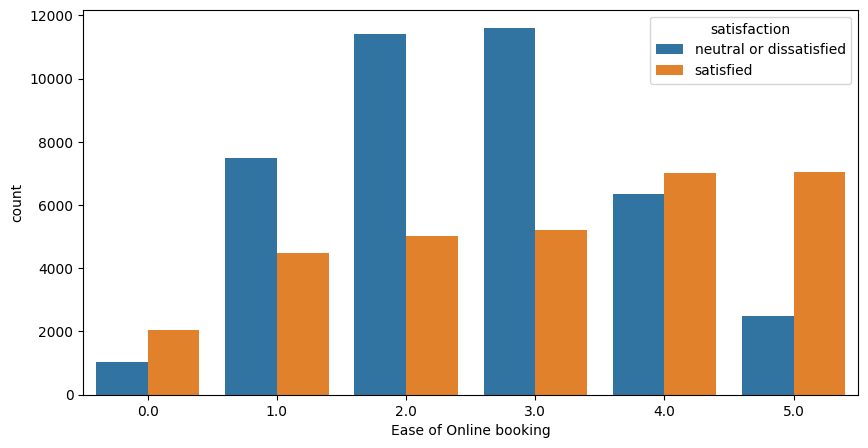

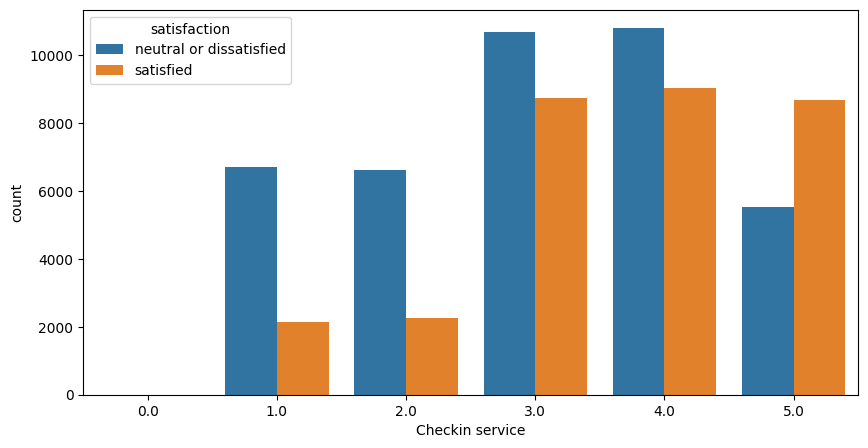

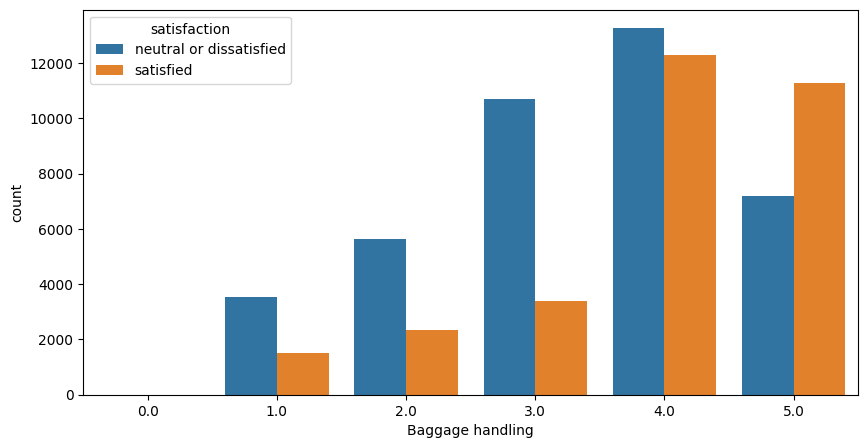

In [61]:
plot_ordinal(ordinal_cols, X_train, y_train)

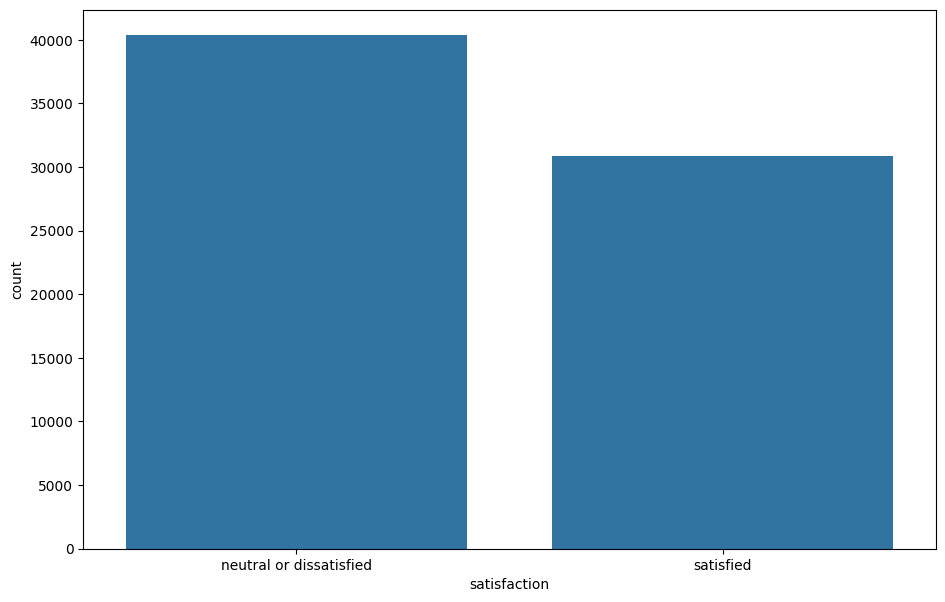

In [64]:
plt.figure(figsize=(11, 7))
sns.countplot(y_train.to_frame(), x="satisfaction")
plt.show()

<font color='#FF6600'>Сделайте выводы по построенным графикам</font>. Полезно было бы упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

Исходя из анализа, категориальные признаки включают: 
`Type of Travel`: 
Личные поездки могут быть связаны с более высокой вероятностью оценок "neutral or dissatisfied". Имеет неравномерное распределение по классам.

`Class`: 
Пассажиры, путешествующие бизнес-классом, вероятно, будут более удовлетворены, чем те, кто путешествует эконом-классом. Неравномерное распределение.

`gender`: 
Прогноз от пола не зависит. Равномерное распределение.

`Customer Type`: 
Пассажиры типа `disloyal customer` с большей вероятностью ставят `neutral or dissatisfied`. Неравномерное распределение у `disloyal customer`, `loyal customer` - равномерное.

Из континуальных признаков: 
`Flight Distance`: 
Более длинные полеты связаны с более низкой вероятностью "neutral or dissatisfied". Разделяемость классов по признаку плохая.

`Departure/Arrival Time Convenient`: 
Линейно зависимые признаки. Распределения для классов похожи. Плохое разделение на классы.

`age`: 
Распределения для классов похожи, однако После 18 лет заметно, что плотность объектов `neutral or dissatisfied` выше. Плохое разделение на классы.

Из порядковых признаков: 
`Inflight Wifi Service`: 
Оценка Wi-Fi значительно влияет на принадлежность к классу "neutral or dissatisfied". 

`Gate location`: 
Равномерное распределение объектов класса satisfied.

Остальные порядковые признаки: 
Вероятно, чем выше оценка, тем с большей вероятностью `satisfied` будет больше.


В общем, Inflight Wifi Service может быть ключевым фактором в определении уровня удовлетворенности пассажиров, среди наиболее важных категориальных признаков можно выделить `Type of Travel` и `Class`, континуальных - `Flight Distance`, среди порядковых признаков важны все.


(Бонус: 0.25 балла) <font color='#9933CC'>По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест </font>

Не сделал(

(0.25 балла) Давайте <font color='#9933CC'>заменим признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.</font>

In [65]:
def apply_log(df, col_name):
    temp_series = df[col_name]
    return np.where(temp_series == 0.0, temp_series, np.log(temp_series))

In [66]:
X_train["Departure Delay in Minutes"] = apply_log(X_train, "Departure Delay in Minutes")
X_train["Arrival Delay in Minutes"] = apply_log(X_train, "Arrival Delay in Minutes")

X_val["Departure Delay in Minutes"] = apply_log(X_val, "Departure Delay in Minutes")
X_val["Arrival Delay in Minutes"] = apply_log(X_val, "Arrival Delay in Minutes")

df_test["Departure Delay in Minutes"] = apply_log(df_test, "Departure Delay in Minutes")
df_test["Arrival Delay in Minutes"] = apply_log(df_test, "Arrival Delay in Minutes")

divide by zero encountered in log


Теперь заново <font color='#9933CC'>постройте графики континуальных признаков</font>

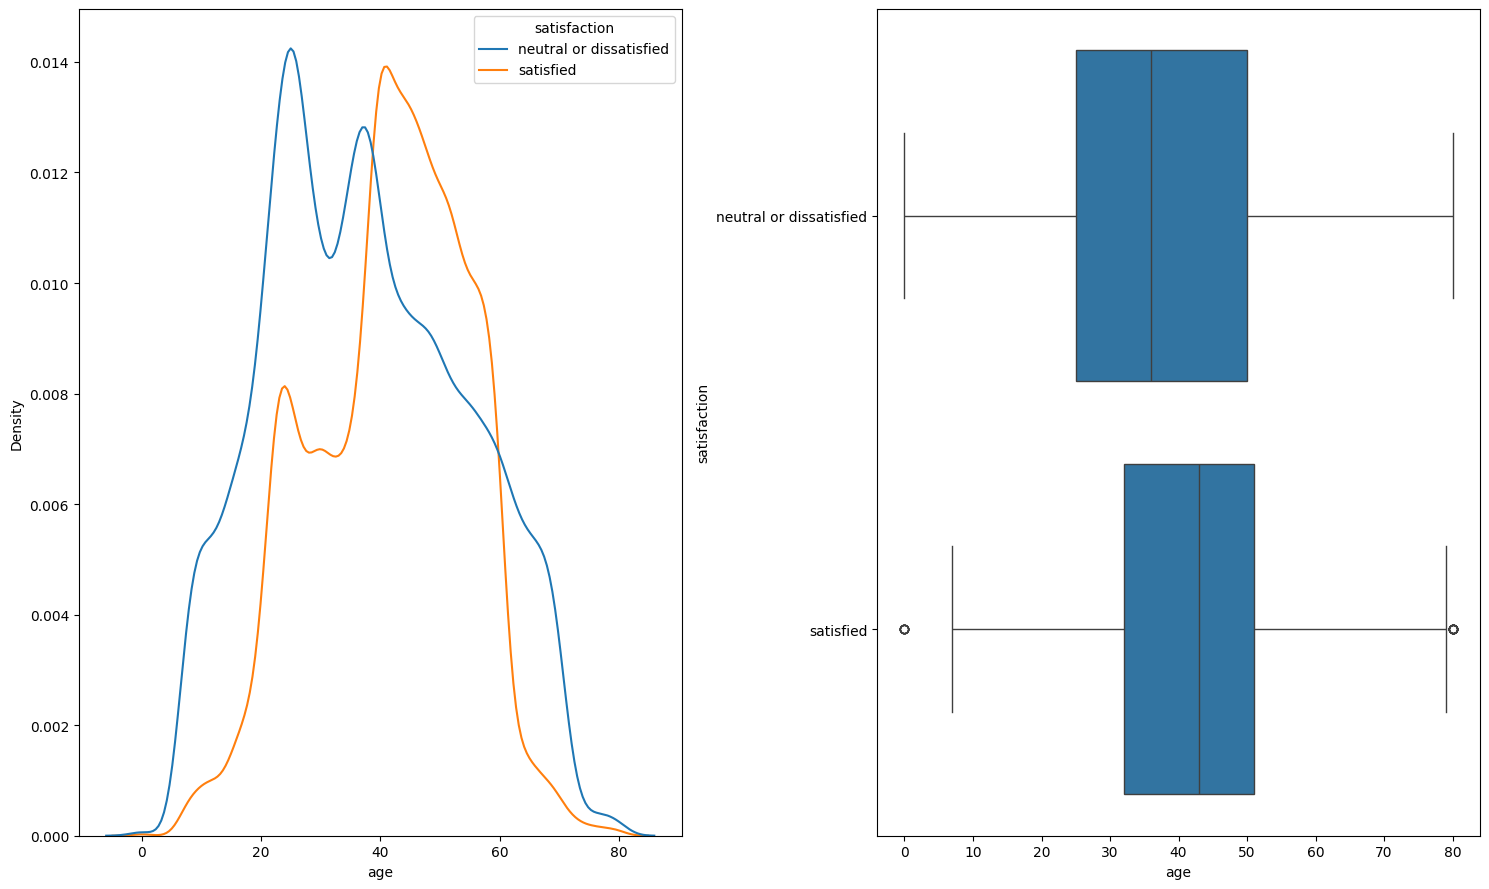

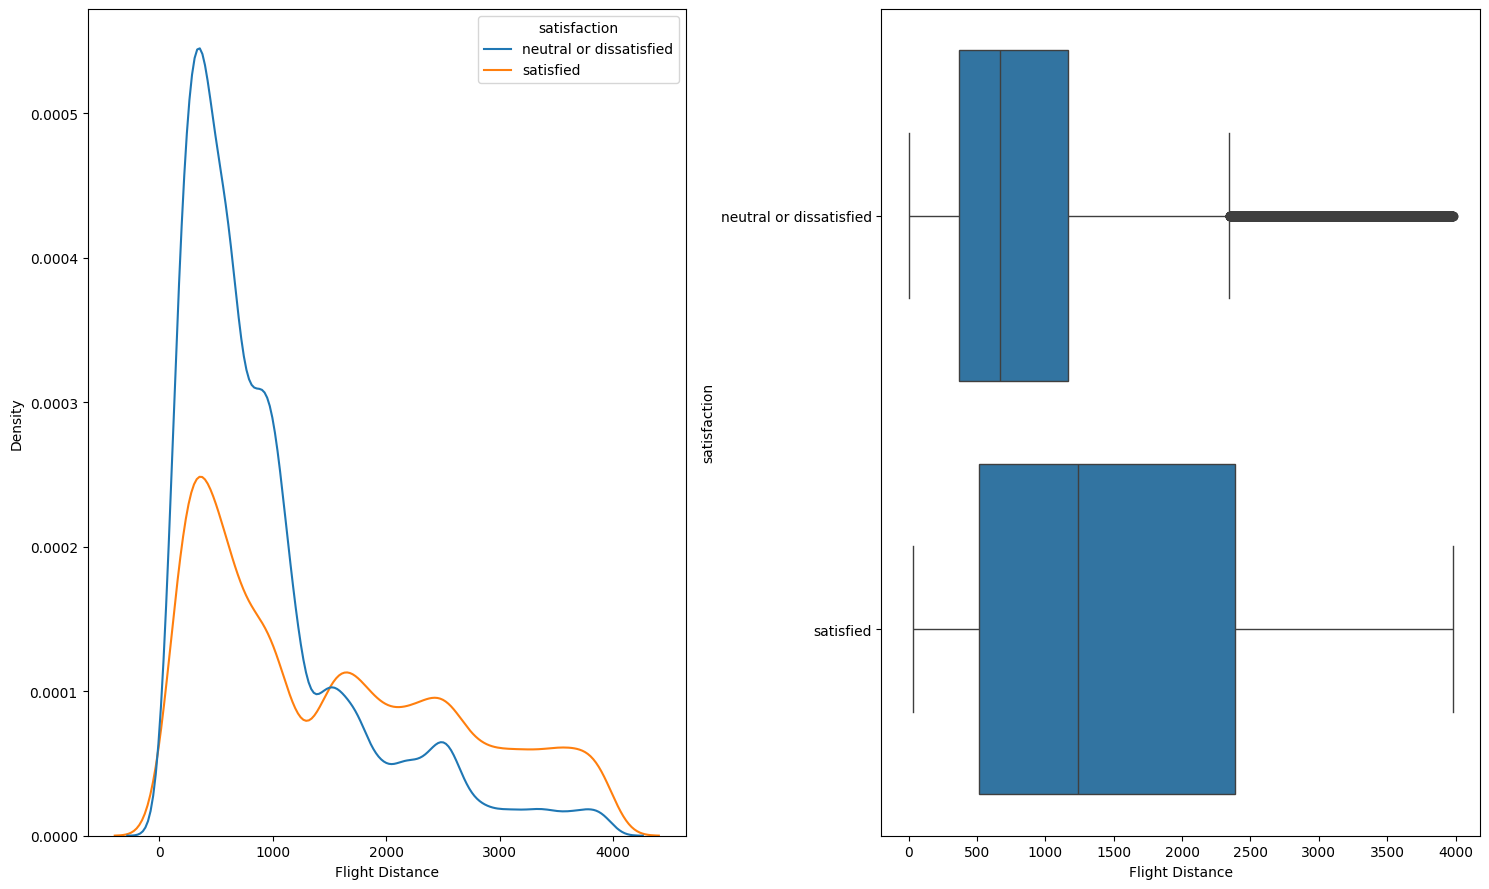

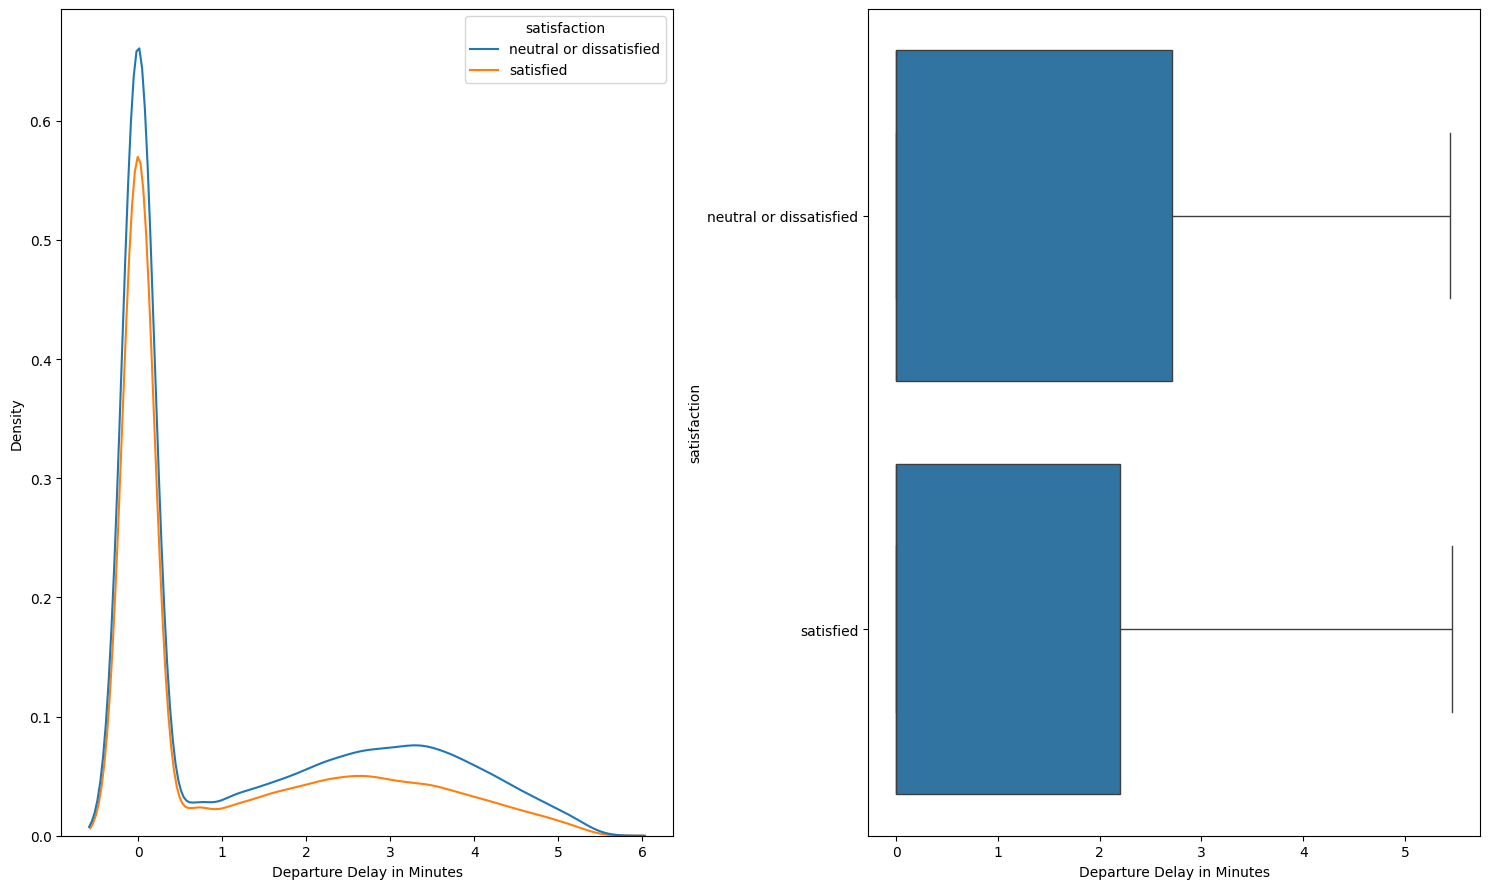

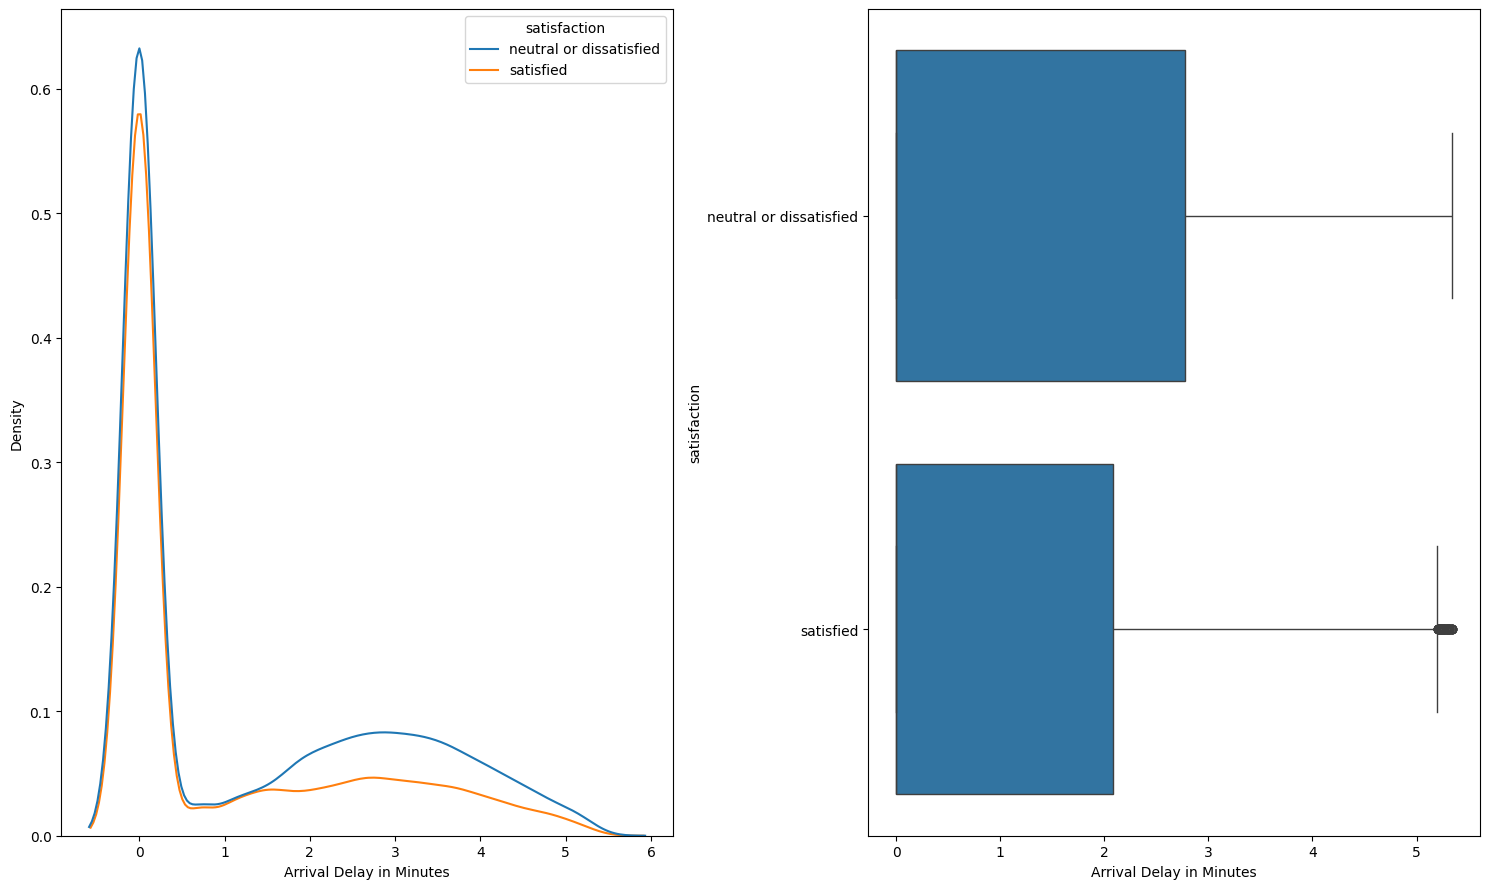

In [67]:
plot_continuous(continuous_cols, X_train, y_train)

<font color='#9933CC'>Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0</font>

In [70]:
y_train.loc[y_train[y_train == "satisfied"].index] = 1
y_train.loc[y_train[y_train == "neutral or dissatisfied"].index] = 0

y_val.loc[y_val[y_val == "satisfied"].index] = 1
y_val.loc[y_val[y_val == "neutral or dissatisfied"].index] = 0

y_train = y_train.astype(int)
y_val = y_val.astype(int)

(0.25 балла) <font color='#9933CC'>Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом</font>. Наблюдений много, так что отрисовка графика вполне может занять несколько минут

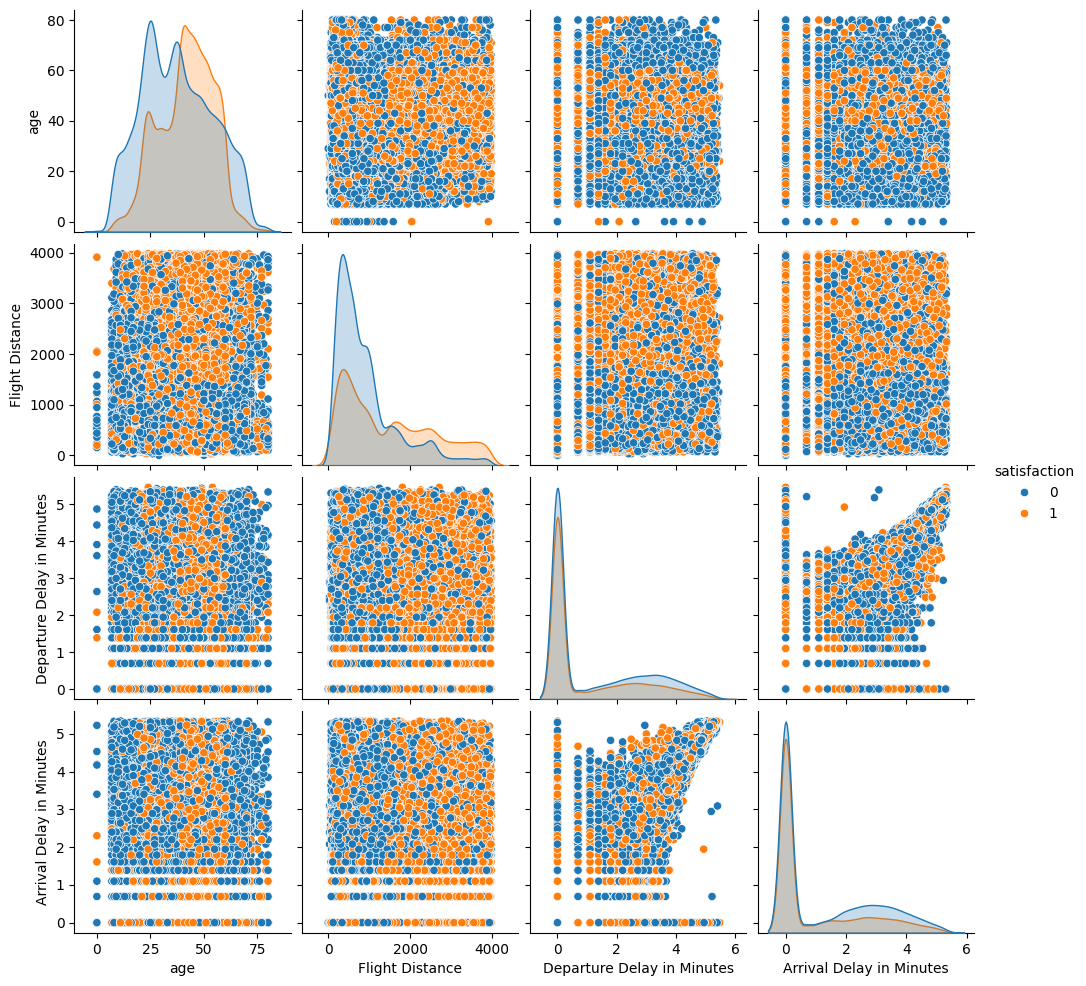

In [71]:
concat_train = pd.concat([X_train[continuous_cols], y_train], axis=1)
sns.pairplot(data=concat_train, hue="satisfaction")

# Decision Tree (3 балла)

(0.5 балла) <font color='#9933CC'>Закодируйте категориальные признаки методом OHE</font>. Для дерева используйте гиперпараметры по умолчанию.

In [34]:
one = OneHotEncoder()
cat_train_one = one.fit_transform(X_train[categorical_cols])
cat_val_one = one.transform(X_val[categorical_cols])

In [35]:
X_train_ohe = pd.concat([X_train[X_train.columns.difference(categorical_cols)].reset_index(drop=True),
                         pd.DataFrame(cat_train_one.toarray(), columns=one.get_feature_names_out())], axis=1)

X_val_ohe = pd.concat([X_val[X_val.columns.difference(categorical_cols)].reset_index(drop=True),
                       pd.DataFrame(cat_val_one.toarray(), columns=one.get_feature_names_out())], axis=1)

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

<font color='#9933CC'>Обучите дерево решений с параметрами по умолчанию на имеющихся данных.</font> Здесь и далее везде, где вас просят что-нибудь обучить, выводите `accuracy_score` для валидационной подвыборки

In [74]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_ohe, y_train)
print(accuracy_score(y_val, dtc.predict(X_val_ohe)))

0.9448160535117057


## Деревья решений. Теоретическая вставка

(0.5 балла) <font color='#9933CC'>Посчитайте bias и variance для построенного дерева.</font> Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [75]:
error_dt, bias_dt, var_dt = bias_variance_decomp(
        dtc, X_train_ohe.values, y_train.values, X_val_ohe.values, y_val.values, 
        loss='0-1_loss',
        random_seed=42)

error_dt, bias_dt, var_dt

(0.05947422781821759, 0.03928126434520297, 0.043936487638533674)

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>Выведите на экран barplot, демонстрирующий оценки важности признаков</font>

<Axes: >

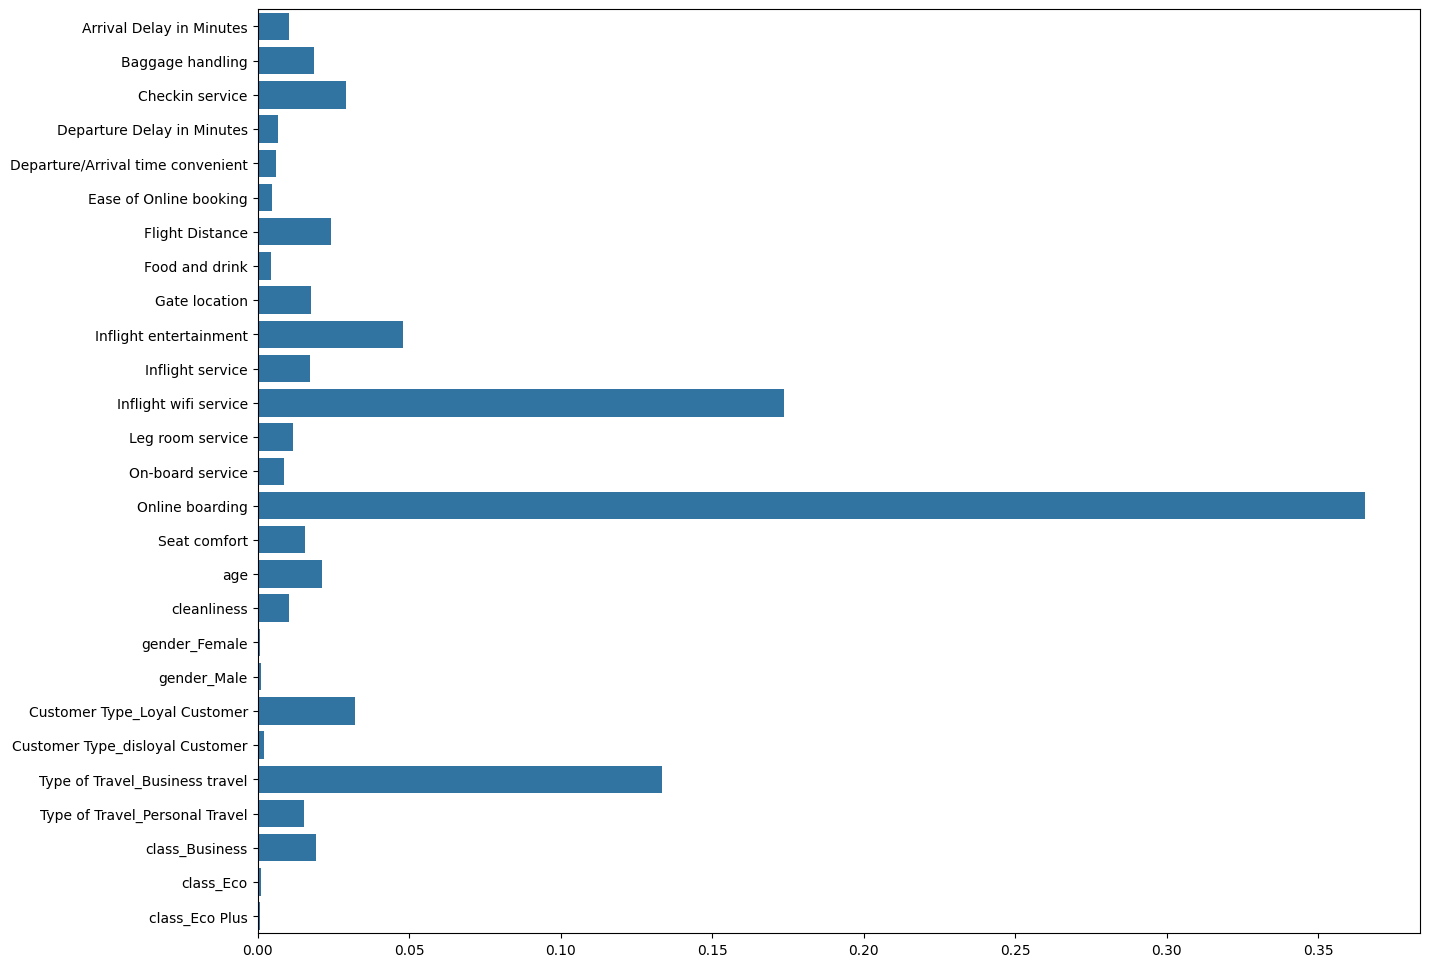

In [77]:
feature_importances = dtc.feature_importances_
feature_names = X_train_ohe.columns
dict_features = dict(zip(feature_names, feature_importances))

plt.figure(figsize=(15, 12))
sns.barplot(dict_features, orient='h')

<font color='#FF6600'>Какие признаки оказались наиболее информативными?</font>

Наиболее информативными оказались: `Online boarding`, `Inflight wifi service` и `Type of travel_Business travel`.


<font color='#9933CC'>Какой глубины получилось дерево? Сколько в нем листьев?</font>

In [78]:
print(f"Глубина дерева: {dtc.get_depth()}")
print(f"Количество листьев: {dtc.get_n_leaves()}")

Глубина дерева: 33
Количество листьев: 1991


<font color='#9933CC'>Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева</font>. <font color='#FF6600'>Насколько упало качество на тесте?</font>

In [80]:
top_features_indices = feature_importances.argsort()[-2:][::-1]
X_top2_features_train = X_train_ohe.loc[:, list(feature_names[top_features_indices])]
X_top2_features_val = X_val_ohe.loc[:, list(feature_names[top_features_indices])]

dtc_depth_5 = DecisionTreeClassifier(max_depth=5)

dtc_depth_5.fit(X_top2_features_train, y_train)

print(f'Точность модели с деревом глубиной 5 и двумя наиболее важными признаками: {accuracy_score(y_val, dtc_depth_5.predict(X_top2_features_val))}')

Точность модели с деревом глубиной 5 и двумя наиболее важными признаками: 0.8251032854613417


Качество упало на 12%.


(0.25 балла) <font color='#9933CC'>С помощью graphviz постройте получившееся дерево решений</font>. <font color='#FF6600'>Почему предикаты в нем не целые, а кратны 1/2?</font>

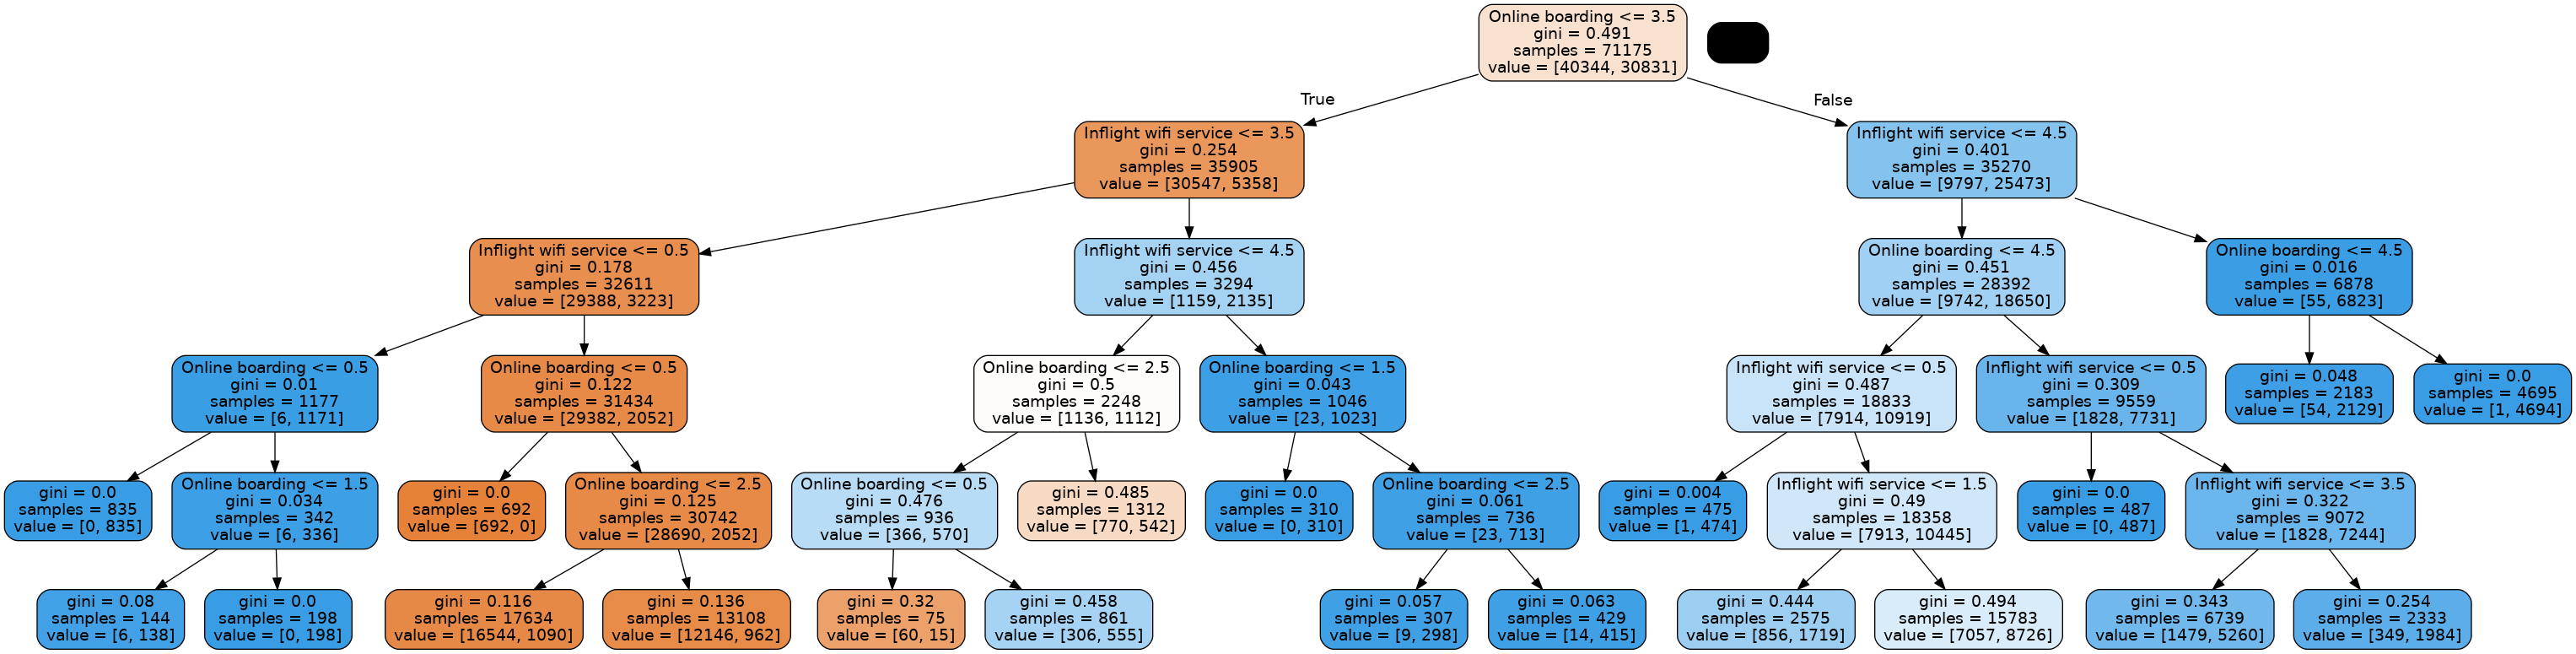

In [88]:
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus
import io

dot_data = io.StringIO()

export_graphviz(dtc_depth_5, out_file=dot_data, filled=True, rounded=True, feature_names=list(feature_names[top_features_indices]))

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

Дерево делит выборку по среднему значению между объектами выборки. Учитывая, что признак в вершине (аналогично другим признакам) принимает значения в виде целых чисел, то его среднее значение может оказаться кратным 1 или 0.5, соответственно с определенной вероятностью можно получить оптимальное значение, кратное 0.5, что и получилось в нашем дереве.

<font color='#9933CC'>Теперь постройте дерево той же глубины 5 для 2-х наиболее информативных континуальных (по договорённости) признаков</font>

In [92]:
top_features = list(feature_names[feature_importances.argsort()[::-1]])
top2_continuos = [f for f in top_features if f in continuous_cols][:2] 
X_top2_features_train = X_train_ohe.loc[:, top2_continuos]
X_top2_features_val = X_val_ohe.loc[:, top2_continuos]

dtc_depth_5 = DecisionTreeClassifier(max_depth=5)

dtc_depth_5.fit(X_top2_features_train, y_train)

print(f'Точность модели с деревом глубиной 5 и двумя наиболее информативными континуальными признаками: {accuracy_score(y_val, dtc_depth_5.predict(X_top2_features_val))}')

Точность модели с деревом глубиной 5 и двумя наиболее информативными континуальными признаками: 0.6835530198701554


(0.25 балла) <font color='#9933CC'>Отобразите его функцией `plot_tree()` из sklearn</font>. <font color='#FF6600'>Симметричным ли получилось дерево? Это хорошо или плохо?</font>

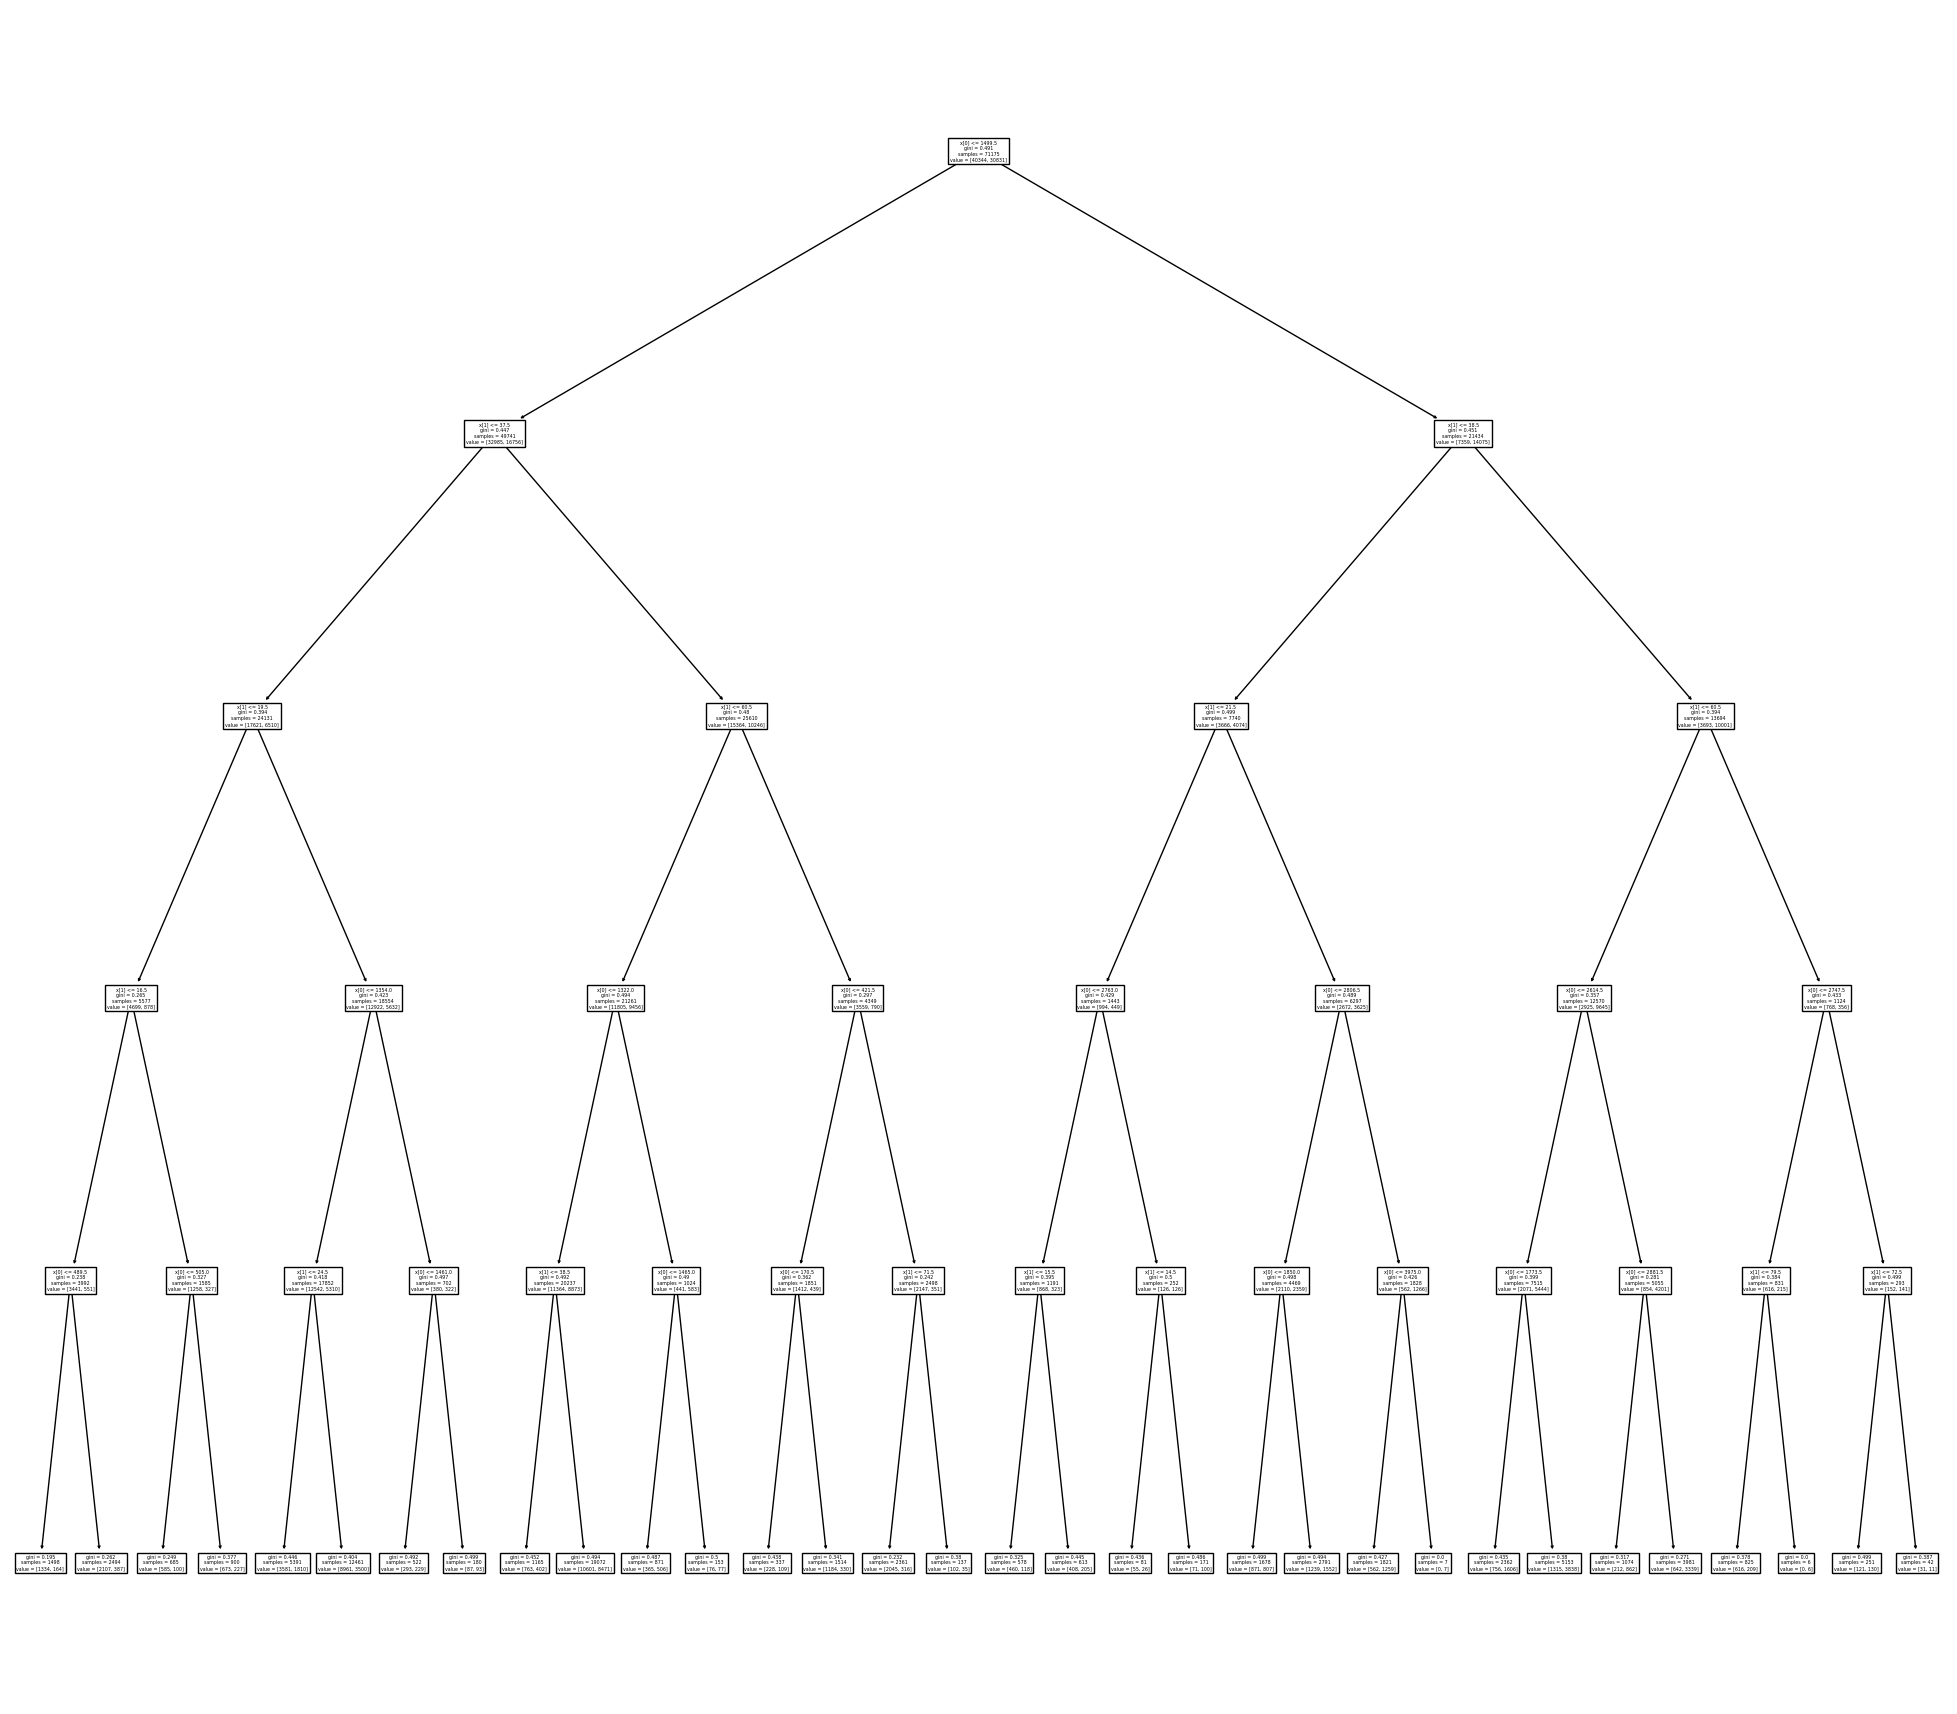

In [93]:
plt.figure(figsize=(25, 22))
plot_tree(dtc_depth_5)
plt.show()

Дерево оказалось несимметричным, так как значение признака на каждом уровне ветвления не повторяется. Однозначно сказать, что это хорошо или плохо нельзя. Несимметричность говорит о том, что данные имеет сложную структуру, которую сложно разделить симметрично и равномерно.

(0.5 балла) <font color='#9933CC'>Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева.</font> Отметьте на графике только первые 100 объектов обучающей выборки

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


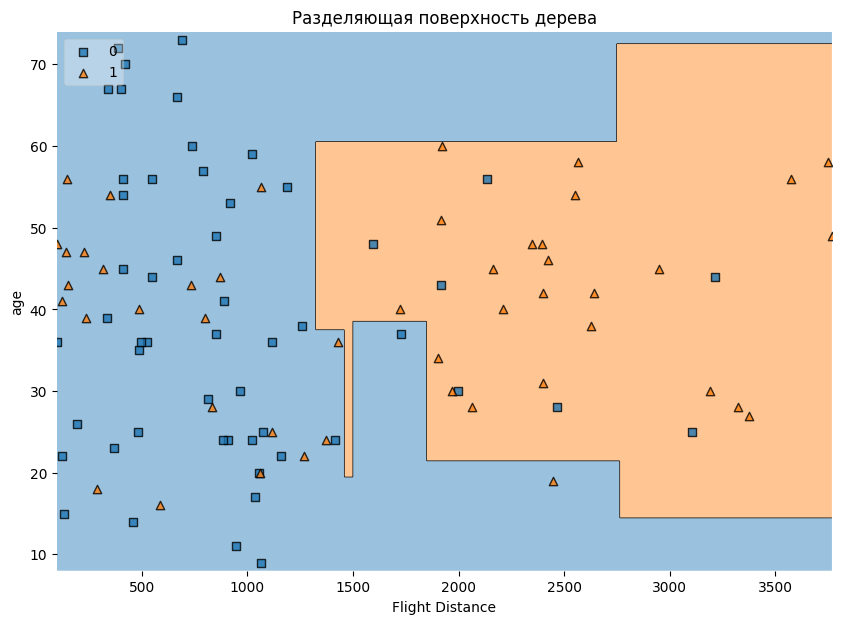

In [95]:
plt.figure(figsize=(10, 7))
plot_decision_regions(X_top2_features_val[:100].values, y_val[:100].values, clf=dtc_depth_5, legend=2)
plt.xlabel(X_top2_features_val.columns[0])
plt.ylabel(X_top2_features_val.columns[1])
plt.title("Разделяющая поверхность дерева")
plt.show()

## Деревья решений. Теоретическая вставка 2

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


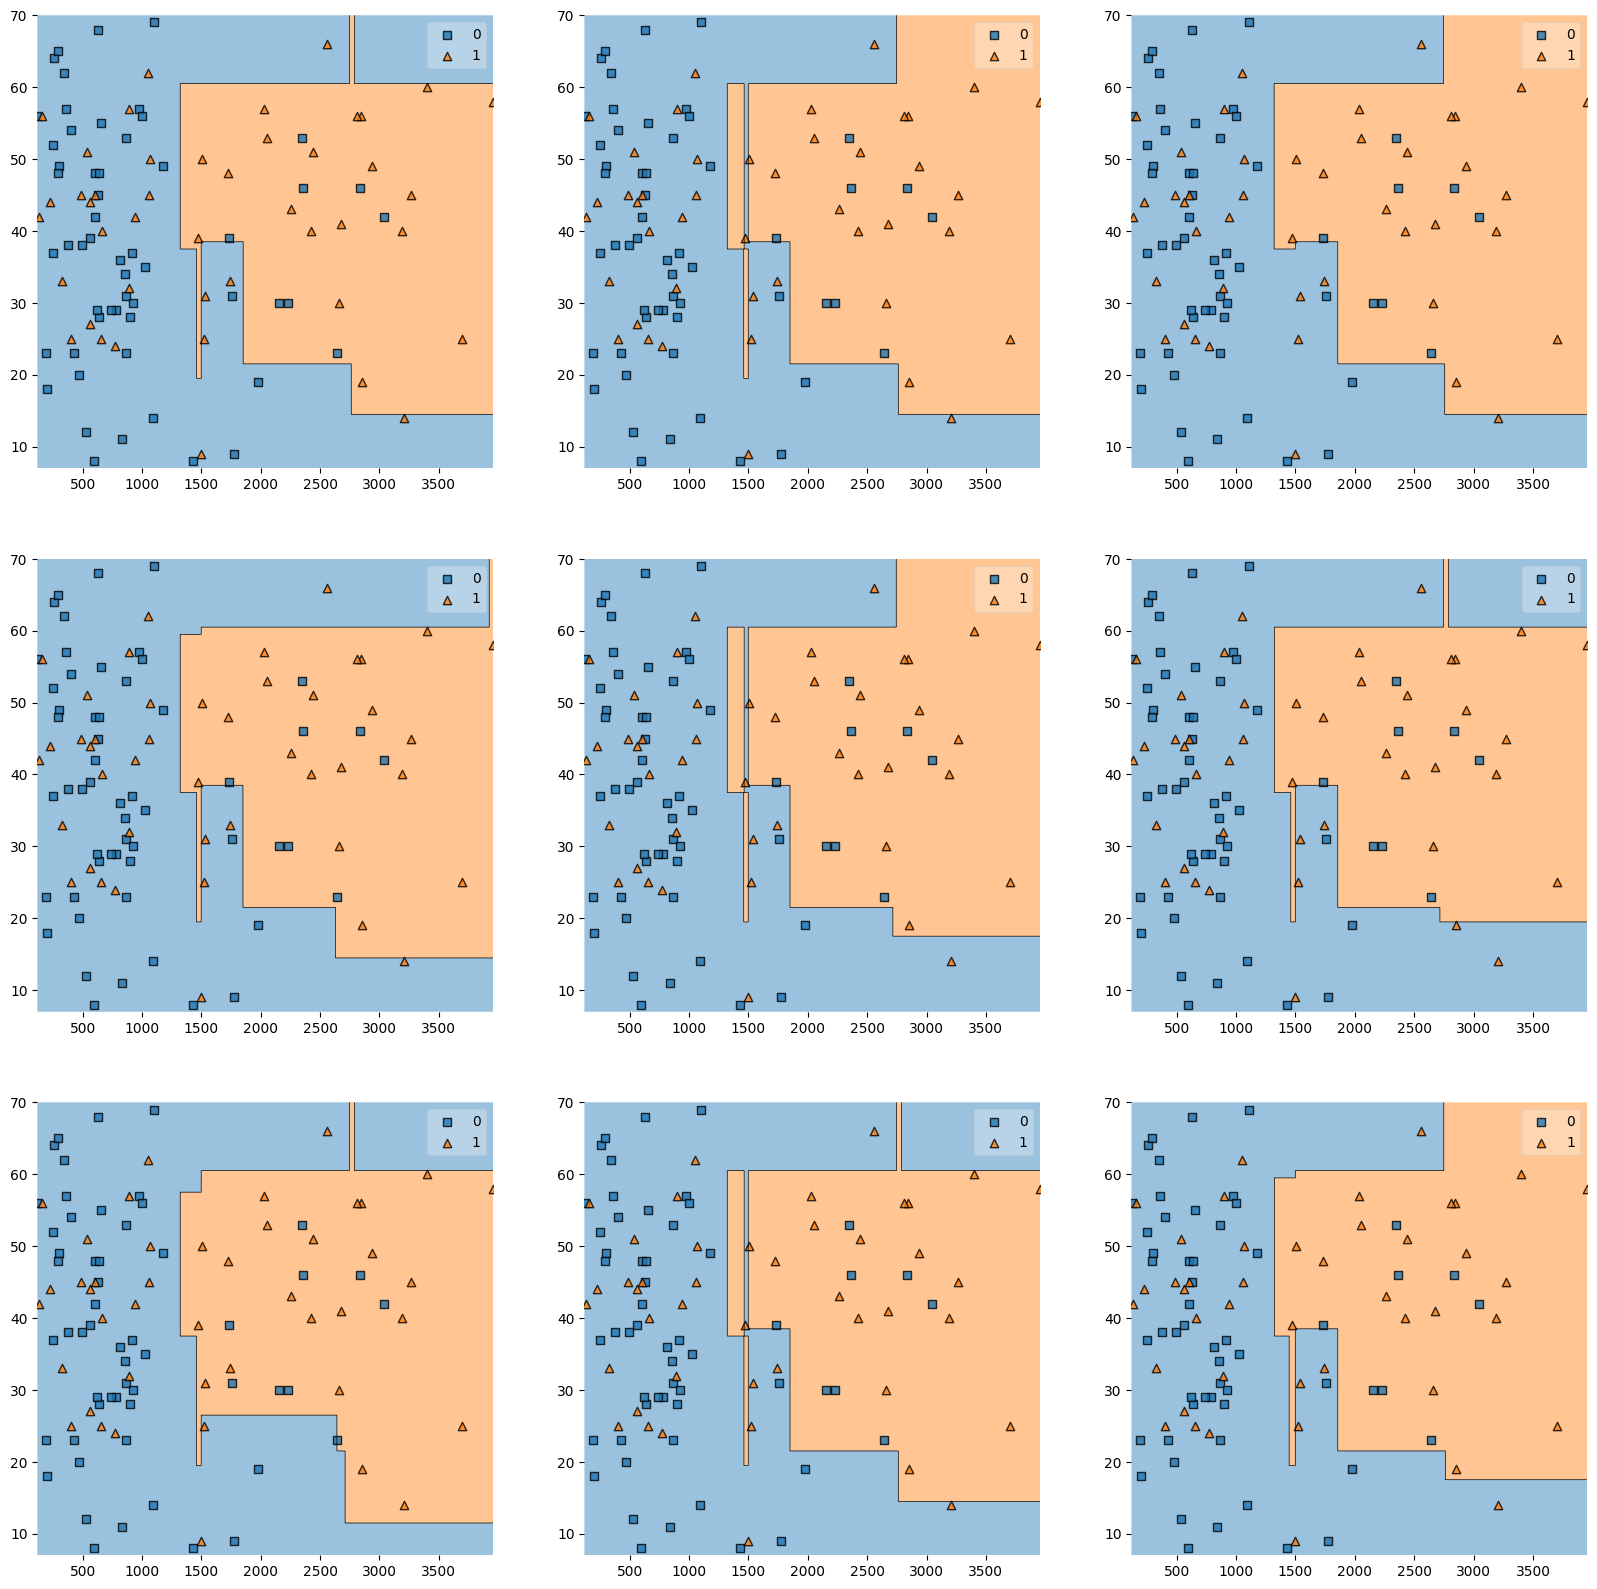

In [96]:
# change X_train_example to your equivalent

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_top2_features_train.index, size=X_top2_features_train.shape[0] - 10000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_top2_features_train.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_top2_features_train.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

Мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [97]:
# change X_train_enc into your ohe-encoded train set

%time 
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_ohe, y_train)
    y_predicted_train = DT.predict(X_train_ohe)
    y_predicted_val = DT.predict(X_val_ohe)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 2.86 µs


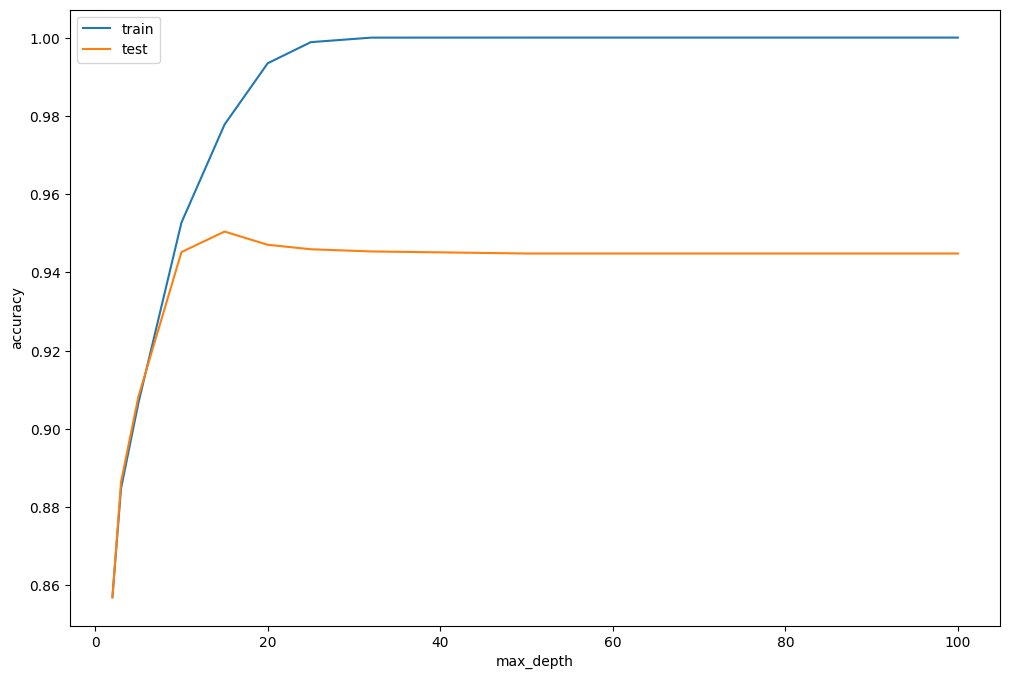

In [98]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>На кроссвалидации подберите оптимальные гиперпараметры для дерева решений</font> *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*. <font color='#FF6600'>Удалось ли улучшить качество предсказаний подбором гиперпараметров?</font>

In [100]:
parameters = {
    "max_depth": np.arange(75, 80, 1),
    "max_leaf_nodes": np.arange(200, 300, 1)
}
dtc = DecisionTreeClassifier()
gs_dtc = GridSearchCV(dtc, parameters, cv=5, verbose=3)
gs_dtc.fit(X_train_ohe, y_train)

print(accuracy_score(y_val, gs_dtc.predict(X_val_ohe)))

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV 1/5] END ..max_depth=75, max_leaf_nodes=200;, score=0.954 total time=   0.2s
[CV 2/5] END ..max_depth=75, max_leaf_nodes=200;, score=0.956 total time=   0.2s
[CV 3/5] END ..max_depth=75, max_leaf_nodes=200;, score=0.955 total time=   0.2s
[CV 4/5] END ..max_depth=75, max_leaf_nodes=200;, score=0.956 total time=   0.2s
[CV 5/5] END ..max_depth=75, max_leaf_nodes=200;, score=0.955 total time=   0.2s
[CV 1/5] END ..max_depth=75, max_leaf_nodes=201;, score=0.954 total time=   0.2s
[CV 2/5] END ..max_depth=75, max_leaf_nodes=201;, score=0.956 total time=   0.2s
[CV 3/5] END ..max_depth=75, max_leaf_nodes=201;, score=0.955 total time=   0.2s
[CV 4/5] END ..max_depth=75, max_leaf_nodes=201;, score=0.956 total time=   0.2s
[CV 5/5] END ..max_depth=75, max_leaf_nodes=201;, score=0.956 total time=   0.2s
[CV 1/5] END ..max_depth=75, max_leaf_nodes=202;, score=0.954 total time=   0.2s
[CV 2/5] END ..max_depth=75, max_leaf_nodes=2

In [101]:
gs_dtc.best_params_

{'max_depth': 77, 'max_leaf_nodes': 282}

Качество предсказаний удалось улучшить подбором гиперпараметров на 0.012% по сравнению с параметрами по умолчанию.

<font color='#9933CC'> Сохраните лучшее дерево в pickle </font>

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [103]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(gs_dtc.best_estimator_, f)

# Random Forest (4 балла)

<font color='#9933CC'>Обучите случайный лес с параметрами по умолчанию</font>

In [104]:
rfc = RandomForestClassifier()
rfc.fit(X_train_ohe, y_train)
print(accuracy_score(y_val, rfc.predict(X_val_ohe)))

0.9629811790937111


(0.75 балла) <font color='#9933CC'>Выведите калибровочную кривую для полученного ансамбля</font>

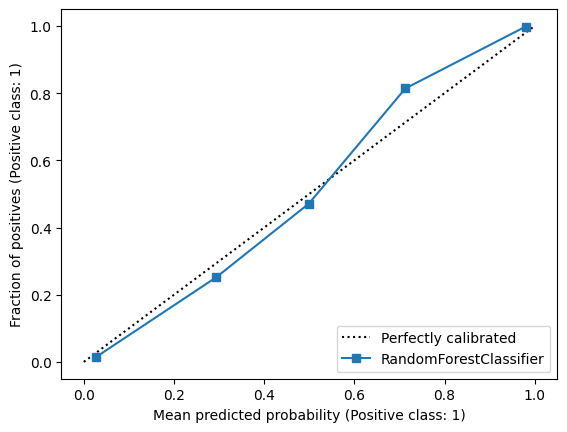

In [105]:
CalibrationDisplay.from_estimator(rfc, X_val_ohe, y_val)
plt.show()

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

<font color='#FF6600'>Вспомните (или выведите), корректно ли деревья предсказывают вероятности?</font>

Доля объектов класса $k$ в $R$:
$$p_k = \frac{1}{|R|}\cdot\sum\limits_{(x, y) \in R}[y_i=k],$$
где $R$ - вершина с наблюдаемыми объектами, принадлежащие $k$ классам: $k \in \{1, \dots, k\}$\.
Решающие деревья - агрегационные. $p_k$ **не является вероятностью**, это - **доля** объектов класса $k$ в $R$.

<font color='#9933CC'>Обучите логистическую регрессию с параметрами по умолчанию и отобразите её калибровочную кривую</font>

UPD: не с параметрами по умолчанию, а так, чтоб сошлась

In [108]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_ohe, y_train)
print(accuracy_score(y_val, logreg.predict(X_val_ohe)))

0.8754344547183421


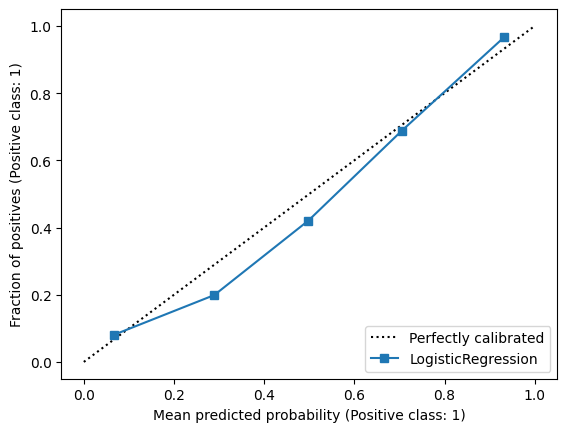

In [109]:
CalibrationDisplay.from_estimator(logreg, X_val_ohe, y_val)
plt.show()

Мы немного переоцениваем предсказанные низкие вероятности

<font color='#FF6600'>Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?</font>

Оптимизация функции потерь логистической регрессии (log-loss) направлена на то, чтобы обучить модель предсказывать реальные вероятности принадлежности объекта к положительному классу.
 
Функция потерь log-loss: $$L(y, b) = -\sum\limits_{i=1}^{l}([y_i=+1]\log b(x_i) + [y_i=-1]\log(1-b(x_i))).$$ 

Математическое ожидание функции потерь: $$\mathbb{E}[L(y, b) | x] = -p(y=+1|x)\log b - (1-p(y=+1|x))\log (1-b).$$

Оптимизация и нахождение оптимального значения $b$: 
Приравниваем производную к ную: $$\frac{\partial}{\partial b} \mathbb{E}[L(y, b) | x] = -\frac{p(y=+1|x)}{b}+\frac{1-p(y=+1|x)}{1-b}=0.$$

Решение этого уравнения дает оптимальное значение $b_0=p(y=+1|x)$, что соответствует вероятности принадлежности объекта $x$ к положительному классу. 

Таким образом, оптимизация log-loss функции при обучении логистической регрессии позволяет модели предсказывать реальные вероятности принадлежности объекта к положительному классу.


(0.75 балла) <font color='#9933CC'>Предлагаем вам попробовать откалибровать вероятности обученного случайного леса</font>. Для этого воспользуйтесь логистической и изотонической регрессиями. <font color='#FF6600'>Интерпретируйте полученные результаты</font>

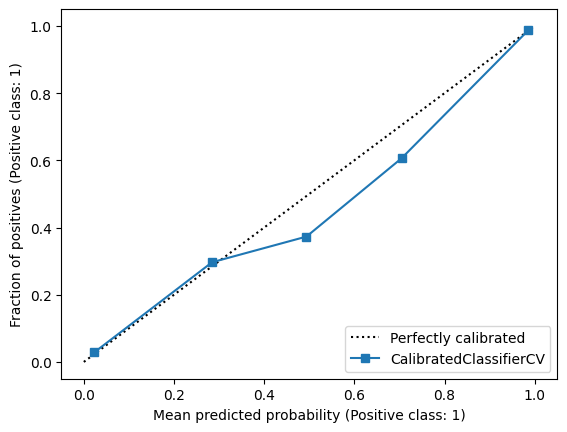

In [110]:
from sklearn.calibration import CalibratedClassifierCV

clf_logistic = CalibratedClassifierCV(rfc, method='sigmoid')
clf_logistic.fit(X_train_ohe, y_train)

CalibrationDisplay.from_estimator(clf_logistic, X_val_ohe, y_val)
plt.show()

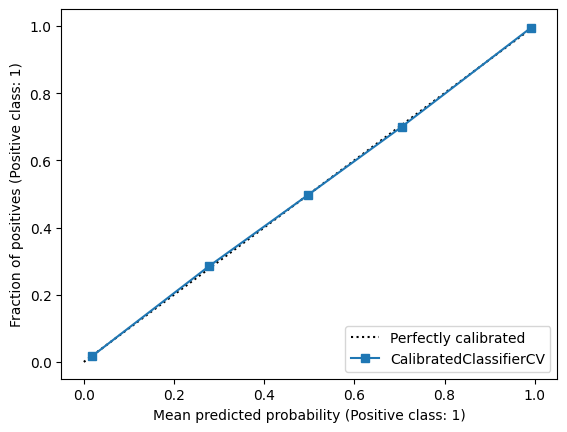

In [111]:
clf_isotonic = CalibratedClassifierCV(rfc, method='isotonic')
clf_isotonic.fit(X_train_ohe, y_train)

CalibrationDisplay.from_estimator(clf_isotonic, X_val_ohe, y_val)
plt.show()

Изотоническая регрессия обеспечила наилучший результат с точки зрения калибровки. У логистической регрессии наблюдаются проблемы в области [0.5, 0.7] - откалиброванная модель завышает реальные вероятности.

<font color='#FF6600'>Опишите другие возвожные подходы к калбировке вероятностей (со ссылками на источники)</font>

Возможно использование вторичных моделей помимо изотонической и логистической регрессии, которые также предсказывают реальные вероятности: 

- Linear Discriminant Analysis (линейный дискриминантный анализ) - Проекция данных на линейное подпространство с целью максимизации разделяющей способности между классами);
- Naive Bayes (наивные Байсовские классификаторы) - Принцип байесовской вероятности для условной независимости признаковв в заданном классе;
- Artificial Neural Networks (наши любимые нейронные сети) - Обучение дополнительных слоев, принимающие предсказанные вероятности и генерирующие калибровочные вероятности.

Данными методами можно откалибровать случайный лес, который не предсказывает вероятности.

[From machinelearningmastery](https://machinelearningmastery.com/probability-calibration-for-imbalanced-classification/)

(1 балл) <font color='#9933CC'>Посчитайте разброс и смещение полученного случайного леса (до калибровки).</font><font color='#FF6600'>Оличаются ли они от полученных для дерева решений? Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?</font>

In [112]:
error_dt, bias_dt, var_dt = bias_variance_decomp(
        rfc, X_train_ohe.values, y_train.values, X_val_ohe.values, y_val.values, 
        loss='0-1_loss',
        random_seed=42)

print(f"Смещение и разброс случайного леса до калибровки: {bias_dt, var_dt}")

Смещение и разброс случайного леса до калибровки: (0.03731392222440816, 0.008644993114302576)


Смещение случайного леса (бэггинг над решающими деревьями) равно смещению решающего дерева (базовый алгоритм), так как по формуле смещение бэггинга равно смещению базового алгоритма. В нашем случае так и получилось.

$$Bias(a_N(x))=Bias(b_n(x)),$$ 
где $a_N(x)$ - алгоритм бэггинга;
$b(x)$ - базовый алгоритм.

Разброс случайного леса меньше, чем у решающего дерева, так как по формуле разброса для бэггинга при отсутствии ковариации между базовыми алгоритмами разброс случайного леса уменьшается в N раз по сравнению с решающим деревом. В нашем случае разброс уменьшился в 5 раз.

$$Var(a_N(x))=\frac{1}{N}Var(b(x))+\frac{N(N-1)}{N^2}Cov(b_n(x), b_m(x)),$$ 
где $a_N(x)$ - алгоритм бэггинга; 
$b(x)$ - базовый алгоритм; 
$N$ - количество базовых алгоритмов в бэггинге. 

<font color='#9933CC'>Вычислите разложение ошибки для логистической регрессии (ванильной, не той, что использовали для калибровки).</font> <font color='#FF6600'>Сравните полученные результаты с предыдущими. Объясните природу этих результатов</font>

In [113]:
error_dt, bias_dt, var_dt = bias_variance_decomp( 
        logreg, X_train_ohe.values, y_train.values, X_val_ohe.values, y_val.values,  
        loss='0-1_loss', 
        random_seed=42) 
 
print(f"Смещение и разброс стандартной логистической регрессии: {bias_dt, var_dt}")

Смещение и разброс стандартной логистической регрессии: (0.12446717817561807, 0.004177814938684504)


Так как логистическая регрессия - линейная модель, то ее разброс между базовыми моделями из разных выборок будет меньше, чем у случайного леса, полученные модели которого сильнее зависят от выбранной выборки. Ввиду того, что истинная разделяющая поверхность имеет нелинейную форму, линейная модель (разделяющая поверхность - прямая) хуже разделяет классы и соответственно имеет смещение выше, чем у случайного леса.

(1 балл) <font color='#9933CC'>Попробуйте подобрать оптимальные гиперпараметры, используя `RandomizedSearchCV`</font>. Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [130]:
from scipy.stats import uniform
params = {
    "n_estimators": np.arange(2, 500, 5),
    "max_features": np.arange(2, X_train_ohe.shape[1]+1, 1),
    "max_depth": np.arange(1, 300, 10),
    "min_samples_split": uniform(loc=0, scale=1),
    "min_samples_leaf": np.arange(2, 20, 1)
                 }
rfc = RandomForestClassifier()
rs_rfc = RandomizedSearchCV(rfc, params, random_state=42, verbose=3, n_jobs=-1, cv=5, n_iter=50)
search = rs_rfc.fit(X_train_ohe, y_train)
print(accuracy_score(y_val, rs_rfc.predict(X_val_ohe)))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
0.9614400944324218


## Случайный лес. Вставка теории

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [132]:
# change X_train_enc into you equivalent

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_ohe[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


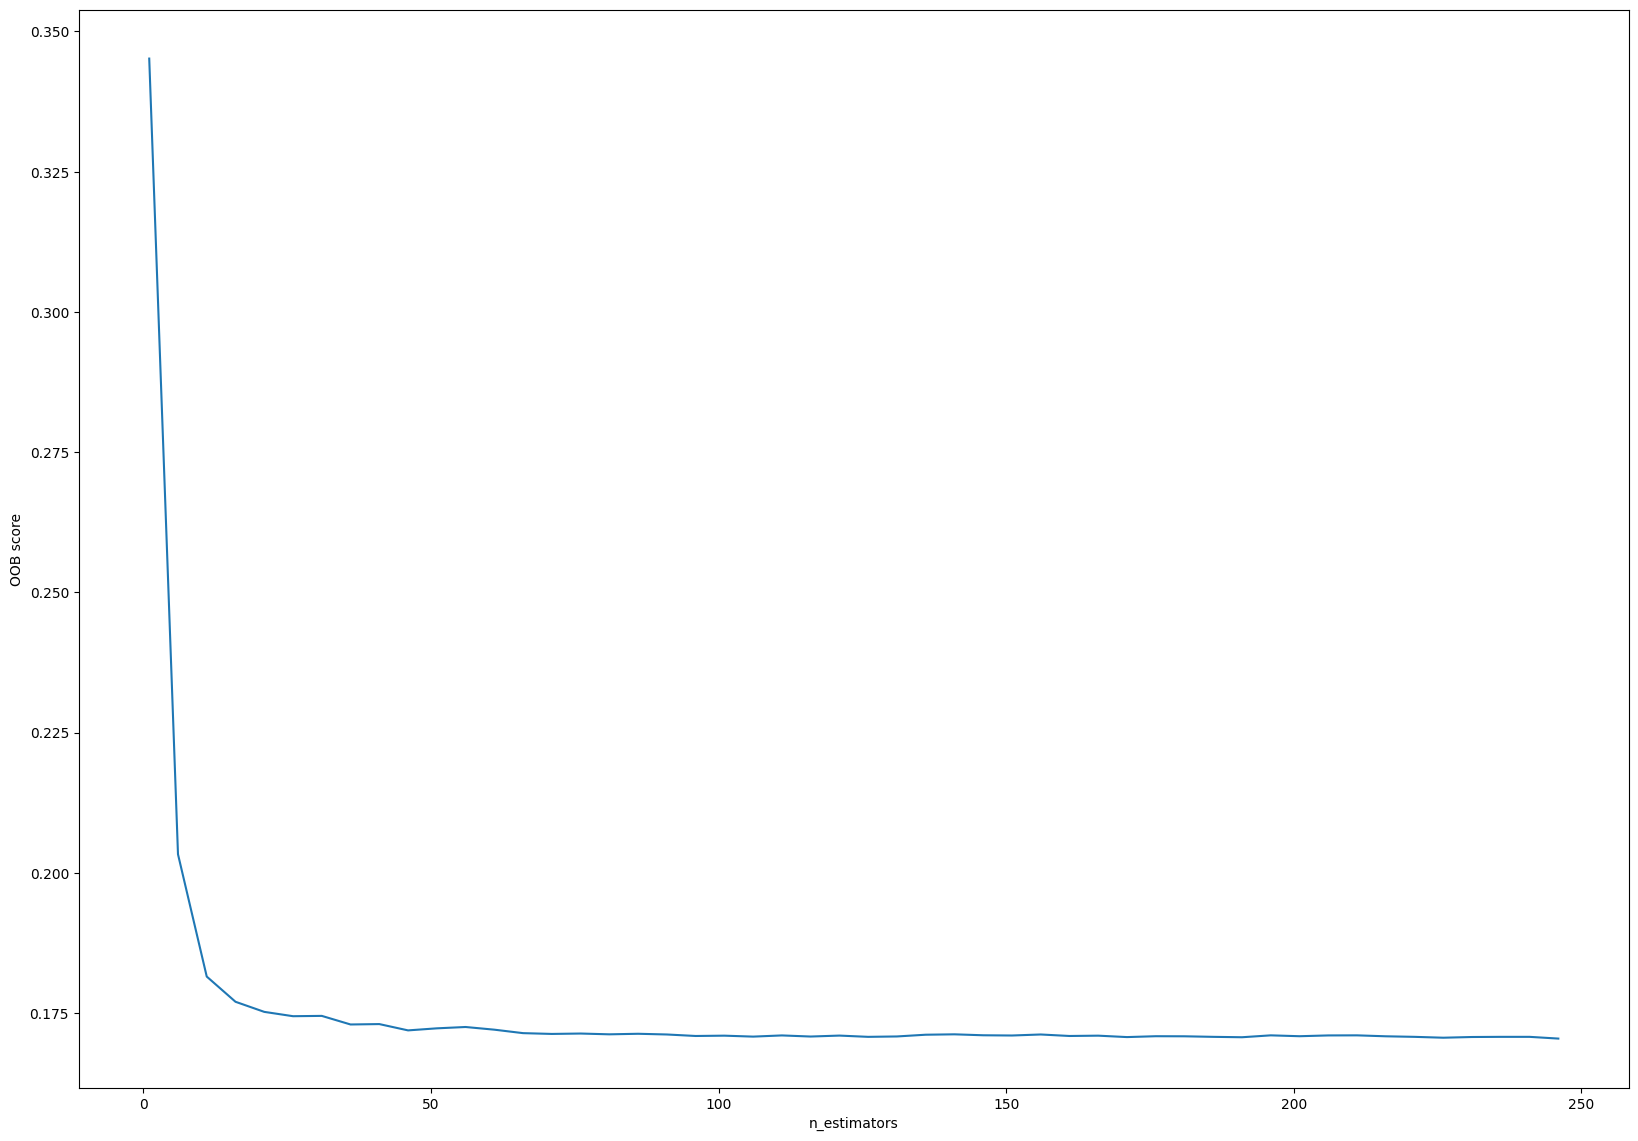

In [133]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

> **Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной 

## Возвращение к задаче

<font color='#9933CC'>Отобразите `feature_importances_` вашего лучшего случайного леса</font>

In [36]:
rfc = RandomForestClassifier()
rfc.fit(X_train_ohe, y_train)
print(accuracy_score(y_val, rfc.predict(X_val_ohe)))

0.9624237654928192


<Axes: >

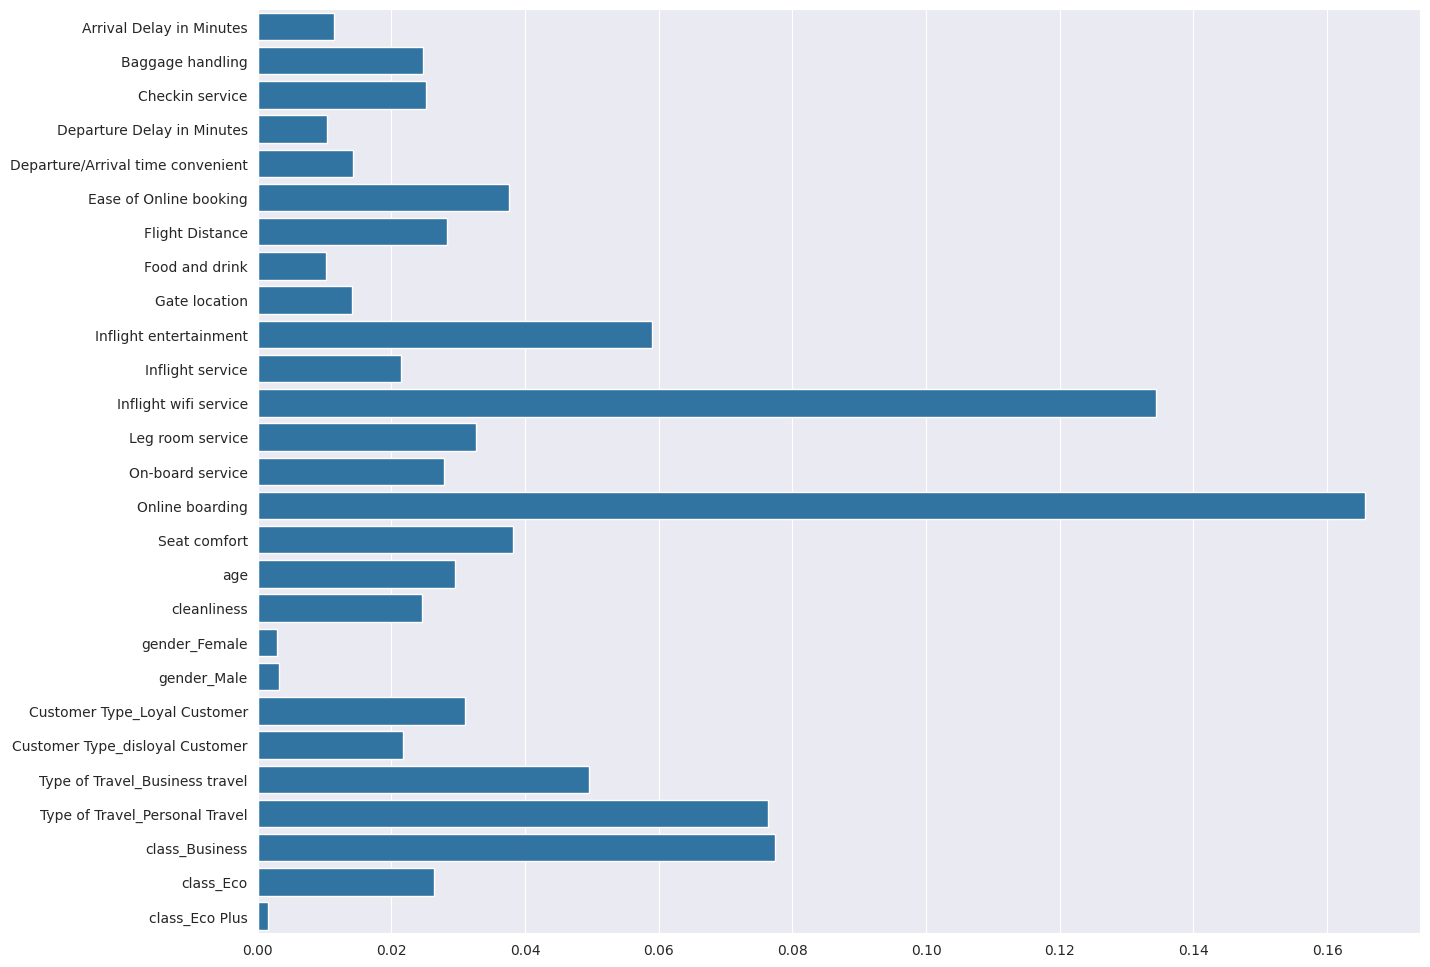

In [37]:
feature_importances_rfc = rfc.feature_importances_
feature_names_rfc = X_train_ohe.columns
dict_features_rfc = dict(zip(feature_names_rfc, feature_importances_rfc))

plt.figure(figsize=(15, 12))
sns.barplot(dict_features_rfc, orient='h')

(0.5 балла) <font color='#9933CC'>Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму</font>

In [38]:
with open("DT.pkl", "rb") as f:
    dtc = pickle.load(f)

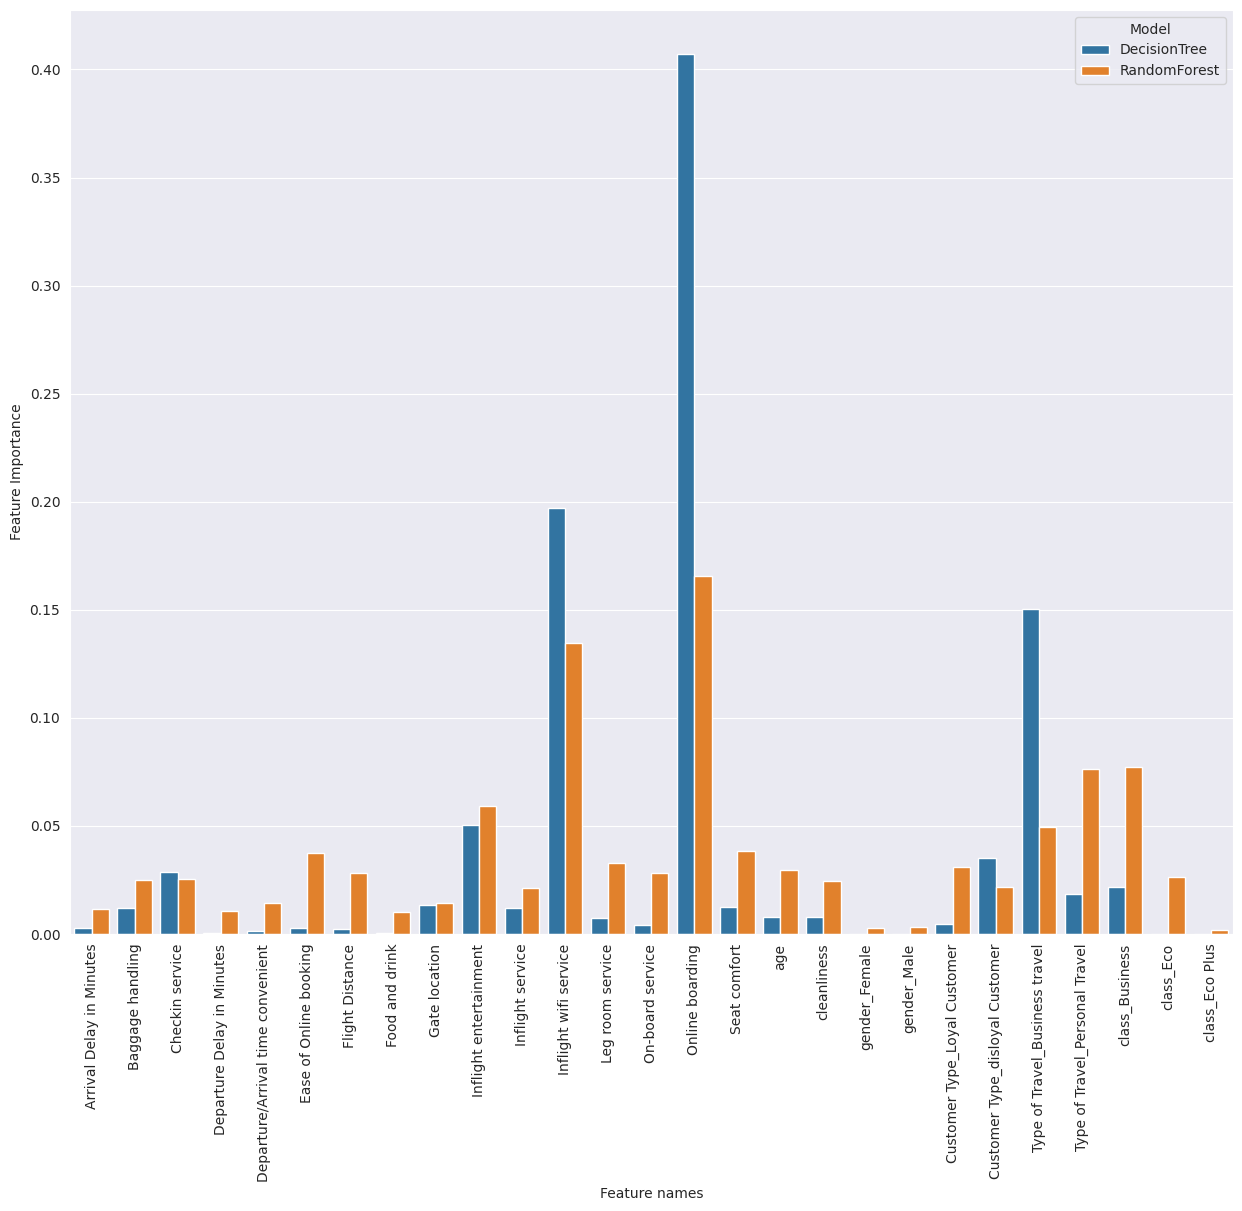

In [39]:
dtc_feature_importances = dtc.feature_importances_ 
rfc_feature_importances = rfc.feature_importances_ 
feature_names = X_train_ohe.columns 
dict_features = dict(zip(feature_names, [(dtc_ft_imp, rfc_ft_imp) for dtc_ft_imp, rfc_ft_imp in zip(dtc_feature_importances, rfc_feature_importances)])) 
 
fts_col_name = "Feature names" 
df = pd.DataFrame(dict_features).T.reset_index().rename({0: "DecisionTree", 1: "RandomForest"}, axis=1) 
df = df.melt(id_vars="index").rename({"value": "Feature Importance", "variable": "Model", "index": fts_col_name}, axis=1) 
 
plt.figure(figsize=(15, 12)) 
sns.barplot(data=df, x=fts_col_name, y="Feature Importance", hue="Model") 
plt.xticks(rotation=90) 
plt.show()

Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью SHAP</font>. Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

[Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

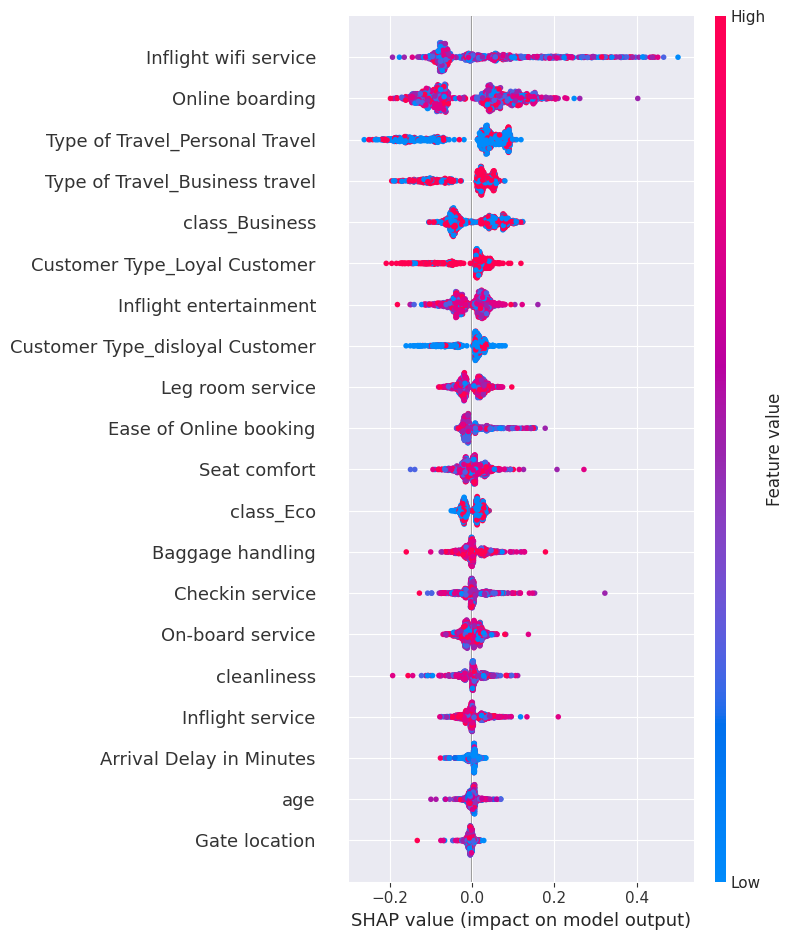

In [71]:
explainer = shap.Explainer(rfc)
shap_values = explainer.shap_values(X_val_ohe.sample(1000))
shap.summary_plot(shap_values[1], X_val_ohe.sample(1000))

<font color='#FF6600'>Опишите полученый график</font>

- Признаки ранжируются в порядке убывания по важности. Так, наиболее важными признакамм, оказывающими максимальное влияние на прогноз, считаются `Inflight wifi service`, `Online Boarding`, `Type of Travel_Personal Travel`/`Type of Travel_Business Travel`. Наименее важные - `Arrival Delay in Minutes`, `age` и `Gate location`.
- Горизонтальное расположение показывает, как связано влияние признака на прогноз класса 1 (значения SHAP). Например, самый правый объект (точка) в `Online Boarding` говорит о том, что высокая оценка данного признака привдоит к увеличению прогноза на 0.4. В `Inflight wifi service` множество объектов вносит положительный вклад (класса 1) в прогноз на отрезке (0.0, 0.5], а некоторая группа объектов (большое скопление точек) вносит отрицательный вклад на прогноз на -0.08. В `Online Boarding` заметны 2 группы точек, которые вносят как отрицательный вклад (около -0.1), так и положительный вклад (около 0.1) в прогноз. Если рассмотреть, например, признаки `age` и `Gate location`, то заметно, что большая часть объектов не оказывает влияния на прогноз, так как точки сгруппированы около 0.0.
- Цвет показывает, имеет ли признак высокое или низкой значение для объекта набора данных. В `Type of Travel_Personal Travel` преобладают объекты с низким значением признака (с низкой оценкой), а в `Type of Travel_Business Travel` наоборот - с высоким значеним (высокая оценка признака). В `class_Business` видно, что количество низких оценок и высоких сбаллансированно. 

<font color='#FF6600'>Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется? </font>

- Для моего годового проекта (Autograde english writing part 1) может сильно пригодиться интерактивное отображение текста, в котором также можно посмотреть важность слов на прогноризрование для классификационной модели. [## Explaining a transformers NLP model](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html)
- К предыдущему пункту можно отнести и возможность построить диаграмму наиболее важных слов (фичей) со значениями SHAP value. Например, shap.plots.bar(...).
- Очень интересным выглядит классификация изображений с SHAP values для положительных предиктов (хоть и не относится к нашей теме). [Explain PyTorch MobileNetV2 using the Partition explainer](https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20MobilenetV2%20using%20the%20Partition%20explainer%20%28PyTorch%29.html) 
![](https://shap.readthedocs.io/en/latest/_images/example_notebooks_image_examples_image_classification_Explain_MobilenetV2_using_the_Partition_explainer_%28PyTorch%29_19_0.png)
- 

Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью LIME</font>

In [80]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_ohe.values, mode='classification', feature_names=X_train_ohe.columns.values.tolist())
explanation = explainer.explain_instance(X_val_ohe.values[3119], rfc.predict_proba, num_features=5) 
explanation.show_in_notebook(show_all=False)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


<font color='#FF6600'>Опишите полученый график</font>

- Полученный график описывает вклад признаков в таргет конкретного объекта нашего датасета. В таблице справа выводятся признаки с наибольшим вкладом в таргет и значение самого признака. По центру выводится, какие признаки влияют на предсказание (0 выделено синим цветом, 1 - оранжевым) и насколько сильно (ранжировка по убыванию). Слева отображаются вероятности предсказания. 

- Выбранный объект с вероятностью в 1.00 отнесен к классу 1. Такие признаки как `Inflight wifi service` = 5 c $x>4$, `Online boarding` = 5 c $x>4$, `Type of Travel_Personal Travel` = 0 c $x\leq 0$, `Type of Travel_Business Travel` = 1 c $0<x\leq1$, `Customer Type_disloyal Customer` = 0 c $x\leq 0$ внесли существенный вклад в вероятность класса 1, отсутсвует вероятность отнесения к классу 0.

In [81]:
explanation.as_list()

[('Inflight wifi service > 4.00', 0.3118027223132453),
 ('Type of Travel_Personal Travel <= 0.00', 0.20443898745250882),
 ('Online boarding > 4.00', 0.14735365111364152),
 ('0.00 < Type of Travel_Business travel <= 1.00', 0.14371374050860183),
 ('Customer Type_disloyal Customer <= 0.00', 0.09429680300372273)]

<font color='#9933CC'>Случайное лес, дающий лучший скор, сохраните в pickle</font>

In [83]:
with open('RFC.pkl', 'wb') as f:
    pickle.dump(rfc, f)

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

Домашка интересная, было полезно "пощупать деревья" и особенно изучить библиотеку SHAP, которая имеет много интересных инструментов для анализа данных (LIME, к сожалению, выглядит устаревшим). По 10-балльной шкале домашка была на 7 баллов сложности. На выполнение ушло 2 полных дня и 2 вечера. Лишнего ничего не было (может быть только LIME, ее можно заменить на какую-нибудь другую библиотеку по новее). Очень понравилось, что в output оставили графики для референса (не хватало такого во 2 домашке), чувствуешь себя поувереннее, когда графики сходятся).